# Проект: Обучение с учителем: качество модели

**Описание и цель проекта:**

Интернет-магазин «В один клик» продаёт разные товары. Отчёт за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.
Необходимо разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность. Для этого необходимо:

* построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца;

* включить в исследование дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца;

* выделить сегменты покупателей и разработать для них персонализированные предложения, используя данные модели и данные о прибыльности клиентов.

## 1. Загрузка данных

Объявим необходмые библиотеки, загрузим датафреймы и выведем их основную информацию:

In [1]:
!pip install shap
!pip install --upgrade shap
!pip install --upgrade scikit-learn
!pip install scikit-learn==1.1.3
!pip install shap -q
!pip install imbalanced-learn 
!pip install phik 

  Using cached scikit_learn-1.6.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.5 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.1.3
    Uninstalling scikit-learn-1.1.3:
      Successfully uninstalled scikit-learn-1.1.3
  Using cached scikit_learn-1.1.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (30.8 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import shap
from shap import Explanation, KernelExplainer, TreeExplainer
from shap.plots import waterfall, beeswarm

from imblearn.over_sampling import ADASYN, SMOTENC

from phik import phik_matrix
from phik.report import plot_correlation_matrix

import statsmodels.stats.outliers_influence as influence
from statsmodels.tools.tools import add_constant  
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer 
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.datasets import make_classification

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler,
    RobustScaler
)


In [3]:
df1 = pd.read_csv('/datasets/market_file.csv')
display(df1)
display(df1.info())

df2 = pd.read_csv('/datasets/market_money.csv')
display(df2)
display(df2.info())

df3 = pd.read_csv('/datasets/market_time.csv')
display(df3)
display(df3.info())

df4 = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')
display(df4)
display(df4.info())

id Покупательская активность Тип сервиса Разрешить сообщать  \
0     215348                 Снизилась     премиум                 да   
1     215349                 Снизилась     премиум                 да   
2     215350                 Снизилась   стандартт                нет   
3     215351                 Снизилась   стандартт                 да   
4     215352                 Снизилась   стандартт                нет   
...      ...                       ...         ...                ...   
1295  216643           Прежний уровень    стандарт                 да   
1296  216644           Прежний уровень    стандарт                нет   
1297  216645           Прежний уровень    стандарт                 да   
1298  216646           Прежний уровень    стандарт                 да   
1299  216647           Прежний уровень     премиум                 да   

      Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  \
0                    3.4                     5           121   
1                    4.4                     4           819   
2                    4.9                     3           539   
3                    3.2                     5           896   
4                    5.1                     3          1064   
...                  ...                   ...           ...   
1295                 6.6                     3           318   
1296                 5.1                     4           454   
1297                 4.1                     3           586   
1298                 6.3                     5           645   
1299                 4.0                     5           906   

      Акционные_покупки            Популярная_категория  \
0                  0.00                Товары для детей   
1                  0.75                Товары для детей   
2                  0.14               Домашний текстиль   
3                  0.99                Товары для детей   
4                  0.94                Товары для детей   
...                 ...                             ...   
1295               0.24  Техника для красоты и здоровья   
1296               0.21               Домашний текстиль   
1297               0.20               Домашний текстиль   
1298               0.12  Техника для красоты и здоровья   
1299               0.94  Техника для красоты и здоровья   

      Средний_просмотр_категорий_за_визит  Неоплаченные_продукты_штук_квартал  \
0                                       6                                   2   
1                                       4                                   4   
2                                       5                                   2   
3                                       5                                   0   
4                                       3                                   2   
...                                   ...                                 ...   
1295                                    5                                   3   
1296                                    6                                   2   
1297                                    3                                   2   
1298                                    3                                   3   
1299                                    4                                   5   

      Ошибка_сервиса  Страниц_за_визит  
0                  1                 5  
1                  2                 5  
2                  1                 5  
3                  6                 4  
4                  3                 2  
...              ...               ...  
1295               3                11  
1296               3                 9  
1297               5                 7  
1298               5                 7  
1299               3                12  

[1300 rows x 13 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

None

id               Период  Выручка
0     215348  препредыдущий_месяц      0.0
1     215348        текущий_месяц   3293.1
2     215348     предыдущий_месяц      0.0
3     215349  препредыдущий_месяц   4472.0
4     215349        текущий_месяц   4971.6
...      ...                  ...      ...
3895  216646  препредыдущий_месяц   4725.0
3896  216646     предыдущий_месяц   4923.0
3897  216647     предыдущий_месяц   4720.0
3898  216647  препредыдущий_месяц   5183.0
3899  216647        текущий_месяц   4448.3

[3900 rows x 3 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


None

id            Период  минут
0     215348     текущий_месяц     14
1     215348  предыдцщий_месяц     13
2     215349     текущий_месяц     10
3     215349  предыдцщий_месяц     12
4     215350     текущий_месяц     13
...      ...               ...    ...
2595  216645     текущий_месяц     18
2596  216646  предыдцщий_месяц     18
2597  216646     текущий_месяц      7
2598  216647     текущий_месяц     10
2599  216647  предыдцщий_месяц     15

[2600 rows x 3 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


None

id  Прибыль
0     215348     0.98
1     215349     4.16
2     215350     3.13
3     215351     4.87
4     215352     4.21
...      ...      ...
1295  216643     4.44
1296  216644     6.11
1297  216645     3.29
1298  216646     4.03
1299  216647     3.28

[1300 rows x 2 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


None

### Промежуточный вывод:

Данные загружены, соответствуют описанию. 

---

## 2. Предобработка данных

Проведём необходимую предобработку данных.

Первый датафрейм:

* пропуски и дубликаты отсутствуют;
* удалим неявные дубликаты в столбце `Тип сервиса`.

Второму и четвёртому датафреймам предобработка не требуется.

Третий датафрейм:

* пропуски и дубликаты отсутствуют;
* исправим ошибку в столбце `Период`.


In [4]:
df1['Тип сервиса'] = df1['Тип сервиса'].apply(lambda x: 'стандарт' if x == 'стандартт' else x)

df3['Период'] = df3['Период'].apply(lambda x: 'предыдущий_месяц' if x == 'предыдцщий_месяц' else x)

for i, data in enumerate([df1, df2, df3, df4]):
    print(i+1, 'датафрейм:')
    print('Количество пропусков в столбцах:', data.isna().sum().sum())
    print('Количество полных дубликатов:', data.duplicated().sum(), end='\n\n')

1 датафрейм:
Количество пропусков в столбцах: 0
Количество полных дубликатов: 0

2 датафрейм:
Количество пропусков в столбцах: 0
Количество полных дубликатов: 0

3 датафрейм:
Количество пропусков в столбцах: 0
Количество полных дубликатов: 0

4 датафрейм:
Количество пропусков в столбцах: 0
Количество полных дубликатов: 0



### Промежуточный вывод:

Проверены все четыре датафрейма:

* данные проверены на наличие дубликатов и пропусков - отсутствуют;
* исправлены неявные дубликаты и ошибки в данных.


## 3. Исследовательский анализ данных

Проведём исследовательский анализ данных из каждой таблицы. Необходимо отобрать клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период. 

In [5]:
df2 = df2[~df2['id'].isin(df2.query('Выручка == 0')['id'].unique())]
df1 = df1[df1['id'].isin(df2['id'].unique())]
df3 = df3[df3['id'].isin(df2['id'].unique())]
df4 = df4[df4['id'].isin(df2['id'].unique())]

### Первый датафрейм:

Изучим параметры первого датафрейма. Необходимо проверить данные на наличие аномалий и выбросов. Построим гистограммы распределения количественных признаков, а также круговые диаграммы категориальных признаков.

Маркет_актив_6_мес
count              1297.00
mean                  4.25
median                4.20
max                   6.60
min                   0.90

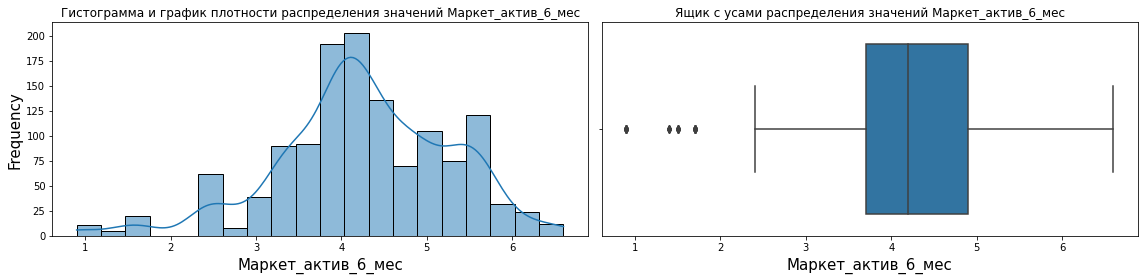

Маркет_актив_тек_мес
count                1297.00
mean                    4.01
median                  4.00
max                     5.00
min                     3.00

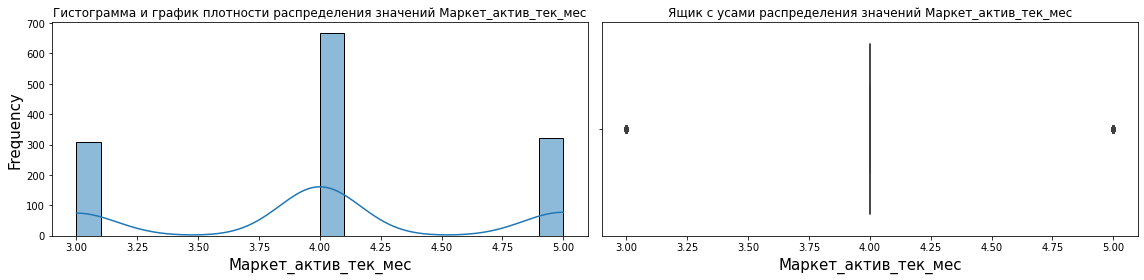

Длительность
count        1297.00
mean          602.99
median        607.00
max          1079.00
min           121.00

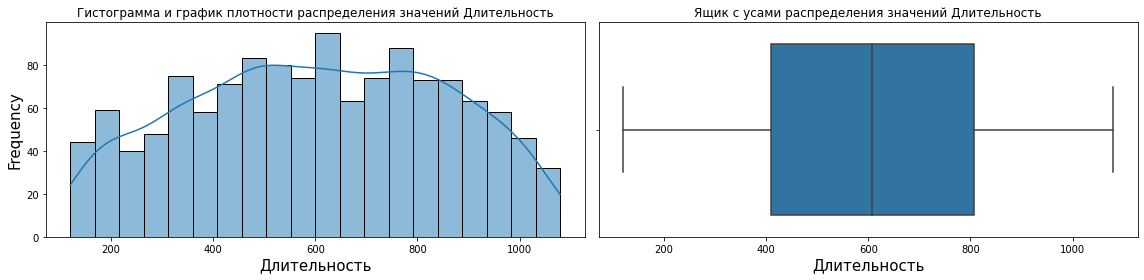

Акционные_покупки
count             1297.00
mean                 0.32
median               0.24
max                  0.99
min                  0.11

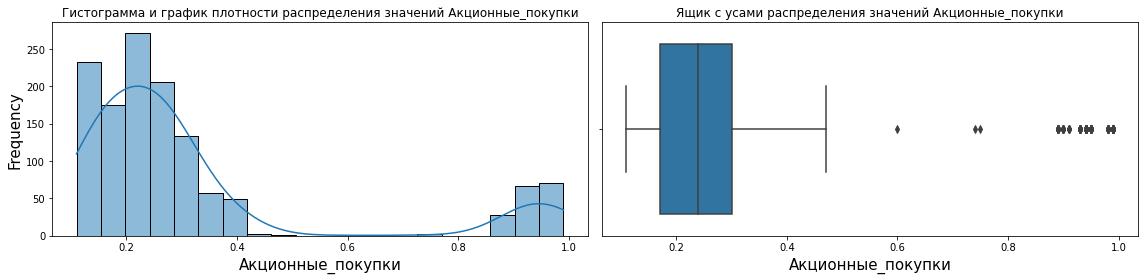

Средний_просмотр_категорий_за_визит
count                               1297.00
mean                                   3.27
median                                 3.00
max                                    6.00
min                                    1.00

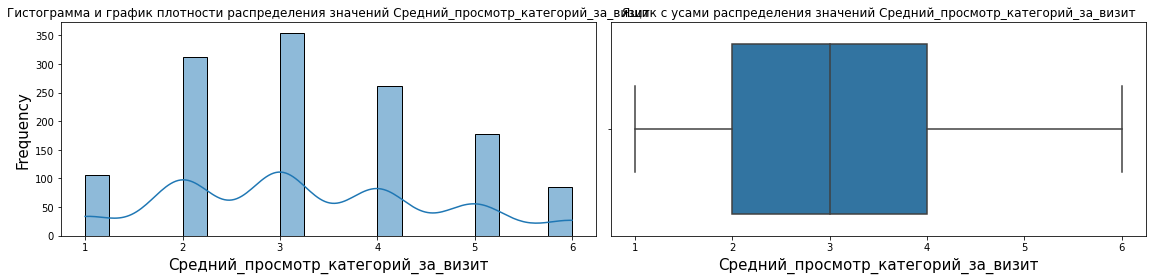

Неоплаченные_продукты_штук_квартал
count                              1297.00
mean                                  2.84
median                                3.00
max                                  10.00
min                                   0.00

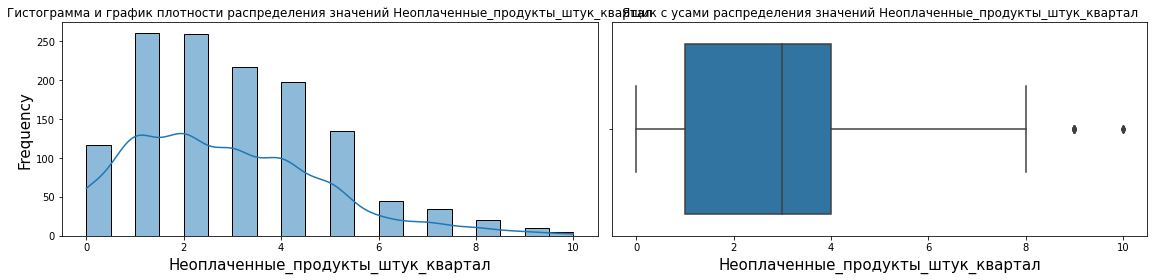

Ошибка_сервиса
count          1297.00
mean              4.18
median            4.00
max               9.00
min               0.00

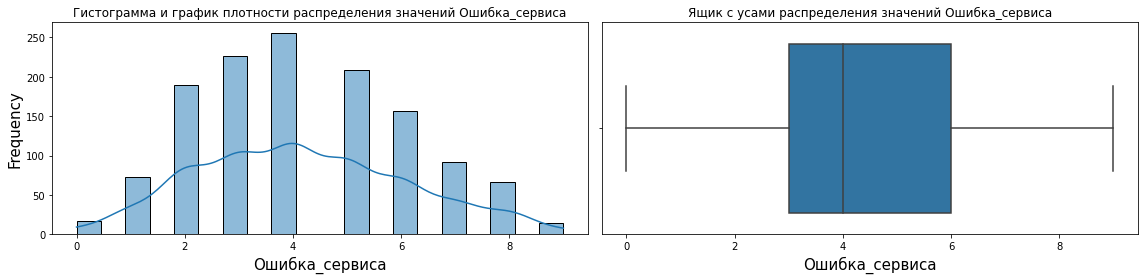

Страниц_за_визит
count            1297.00
mean                8.19
median              8.00
max                20.00
min                 1.00

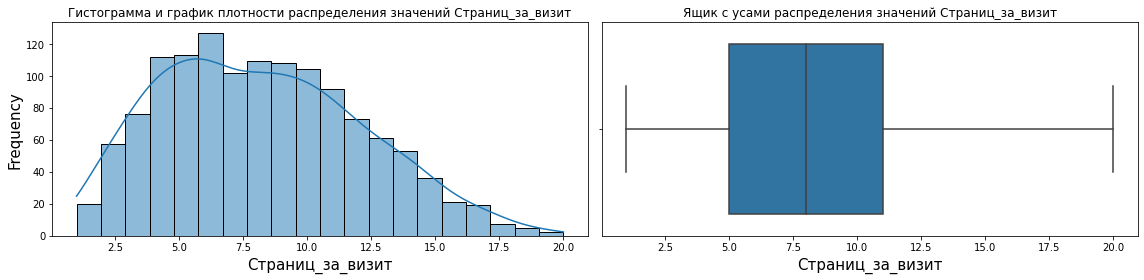

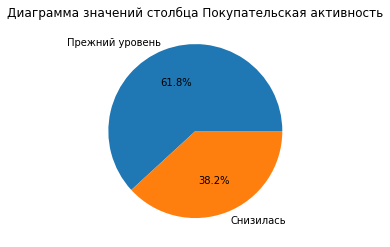

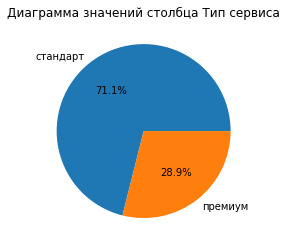

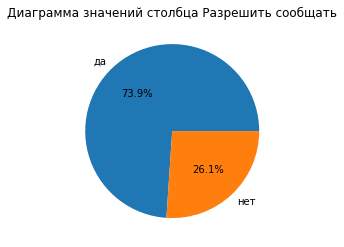

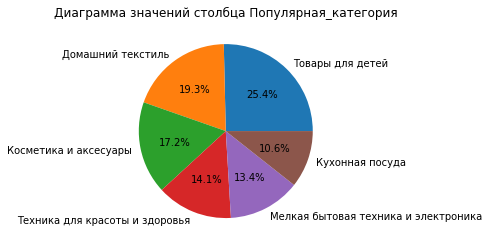

In [6]:
def histogram(data):
    
    rows = data.select_dtypes(include=['float64', 'int64']).columns
    for i, col in enumerate(rows):
        if col != 'id':
            f, ax = plt.subplots(1, 2, figsize=(16, 4))
            display(round(data[col].agg(['count', 'mean', 'median', 'max', 'min']), 2).to_frame())
            sns.histplot(x=data[col], kde=True, multiple='stack', bins=20, ax = ax[0])
            sns.boxplot(x=data[col], ax = ax[1])
            ax[0].set_title('Гистограмма и график плотности распределения значений {}'.format(col))
            ax[0].set_xlabel(col, fontsize=15)
            ax[0].set_ylabel('Frequency', fontsize=15) 
            ax[1].set_title('Ящик с усами распределения значений {}'.format(col))
            ax[1].set_xlabel(col, fontsize=15)   
            plt.tight_layout()
            plt.show()  
    
    for col in data.select_dtypes(include='object').columns:
        plt.pie(x=data[col].value_counts(), labels = data[col].value_counts().index, autopct='%1.1f%%')
        plt.title('Диаграмма значений столбца {}'.format(col))
        plt.show()


histogram(df1)

В столбце `Маркет_актив_6_мес` обнаружены аномальные значения. Скорее всего, это связано с сезонностью предложений: если предположить, что под цифрой "4" подразумевается ноябрь или декабрь, то высокая частота рассылок обуславливается сезоном праздничных покупок и распродаж. Логично, что перед праздникаим и после них активность покупателей будет снижаться, и нет смысла в их тотальной маркетинговой обработке.

В столбце `Длительность` наблюдаются локальные выбросы. Вероятно, это связано с тем, что примерно каждые полгода магазин проводил промо-акции по привлечению новых клиентов. В общем плане распределение выглядит корректно.

В столбце `Акционные_покупки` также наблюдаются локальные выбросы. Возможно, это связано с тем, что существует определённый процент покупателей, ищущих товары исключительно по акции или закупается в основном в период их проведения. Основное распределение выглядит корректно.

В столбце `Неоплаченные_продукты_штук_квартал` распределение искажено. Однако, такая картина вполне возможна: у каждого могут быть в корзине отложенные товары "на потом".

В столбцах `Маркет_актив_тек_мес`, `Средний_просмотр_категорий_за_визит`, `Ошибка_сервиса`, `Страниц_за_визит` наблюдаются нормальные распределения с незначительными смещениями.

---

### Второй датафрейм:

Выручка
count     3891.00
mean      5033.72
median    4959.00
max     106862.20
min       2758.70

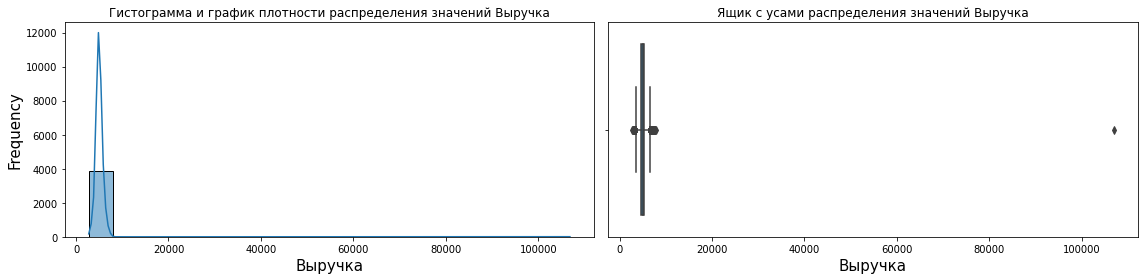

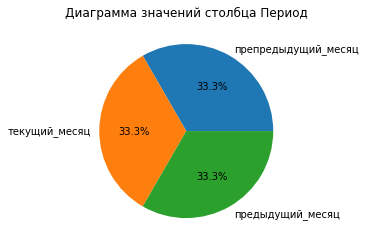

In [7]:
histogram(df2)

Наблюдается выброс в столбце `Выручка`. Возможно, была допущена ошибка в данных, или клиент купил что-то очень дорогое.
Для нивелирования влияния данного выброса на будущие модели МО, заменим данное значение медианным:

Выручка
count   3891.00
mean    5007.53
median  4959.00
max     7799.40
min     2758.70

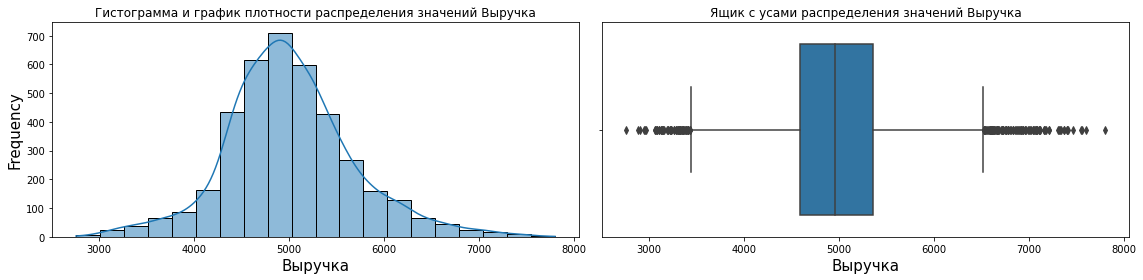

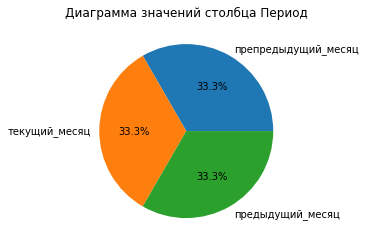

In [8]:
df2['Выручка'] = df2['Выручка'].apply(lambda x: df2['Выручка'].median() if x > 20000 else x)
histogram(df2)

### Третий датафрейм:

минут
count   2594.00
mean      13.34
median    13.00
max       23.00
min        4.00

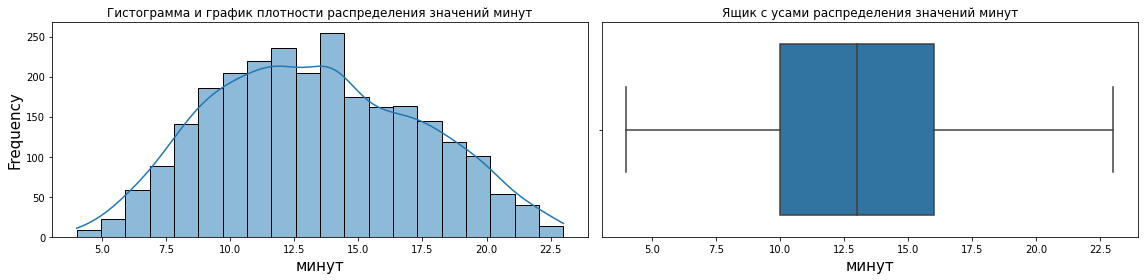

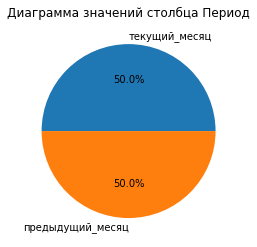

In [9]:
histogram(df3)

В третьем датафрейме распределение данных выглядит корректно.

---

### Четвёртый датафрейм:

Прибыль
count   1297.00
mean       4.00
median     4.04
max        7.43
min        0.86

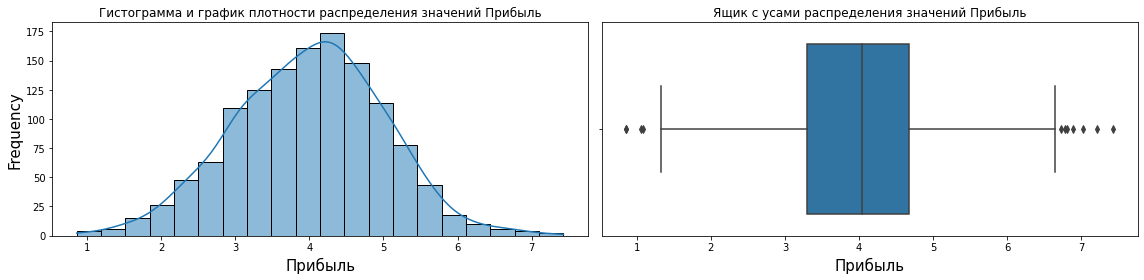

In [10]:
histogram(df4)

В четвёртом датафрейме распределение данных выглядит корректно.

---

### Промежуточные выводы:

* были отобраны клиенты с покупательской активностью не менее трёх месяцев;
* каждый датафрейм был проверен на аномальные значения и выбросы. Для кадого признака было сделано предположение о природе происхождения аномалий, во втором датафрейме выброс был заменён медианным значением.
    
Исследовательский анализ данных завершён.

## 4. Объединение датафреймов

Объединим датафреймы df1, df2 и df3. Данные о прибыли из df4 при моделировании не понадобятся. 

Для обучения столбец `id` в df1 не нужен, поэтому сделаем эти значения индексами.

Необходмо учесть, что данные о выручке и времени на сайте находятся в одном столбце для всех периодов. В итоговой таблице сделаем отдельный столбец для каждого периода.

In [11]:
df1 = df1.set_index('id') 
pvt2 = pd.DataFrame(df2.pivot_table(values='Выручка', index='id', columns='Период'))
pvt2.rename(columns={'предыдущий_месяц': 'Выручка_предыдущий_месяц', 'препредыдущий_месяц': 'Выручка_препредыдущий_месяц', \
                     'текущий_месяц': 'Выручка_текущий_месяц',}, inplace=True)
pvt3 = pd.DataFrame(df3.pivot_table(values='минут', index='id', columns='Период'))
pvt3.rename(columns={'предыдущий_месяц': 'Период_предыдущий_месяц', 'текущий_месяц': 'Период_текущий_месяц',}, inplace=True)

df = df1.join(pvt2, how='outer')
df = df.join(pvt3, how='outer')
df

Покупательская активность Тип сервиса Разрешить сообщать  \
id                                                                
215349                 Снизилась     премиум                 да   
215350                 Снизилась    стандарт                нет   
215351                 Снизилась    стандарт                 да   
215352                 Снизилась    стандарт                нет   
215353                 Снизилась    стандарт                 да   
...                          ...         ...                ...   
216643           Прежний уровень    стандарт                 да   
216644           Прежний уровень    стандарт                нет   
216645           Прежний уровень    стандарт                 да   
216646           Прежний уровень    стандарт                 да   
216647           Прежний уровень     премиум                 да   

        Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  \
id                                                               
215349                 4.4                     4           819   
215350                 4.9                     3           539   
215351                 3.2                     5           896   
215352                 5.1                     3          1064   
215353                 3.3                     4           762   
...                    ...                   ...           ...   
216643                 6.6                     3           318   
216644                 5.1                     4           454   
216645                 4.1                     3           586   
216646                 6.3                     5           645   
216647                 4.0                     5           906   

        Акционные_покупки            Популярная_категория  \
id                                                          
215349               0.75                Товары для детей   
215350               0.14               Домашний текстиль   
215351               0.99                Товары для детей   
215352               0.94                Товары для детей   
215353               0.26               Домашний текстиль   
...                   ...                             ...   
216643               0.24  Техника для красоты и здоровья   
216644               0.21               Домашний текстиль   
216645               0.20               Домашний текстиль   
216646               0.12  Техника для красоты и здоровья   
216647               0.94  Техника для красоты и здоровья   

        Средний_просмотр_категорий_за_визит  \
id                                            
215349                                    4   
215350                                    5   
215351                                    5   
215352                                    3   
215353                                    4   
...                                     ...   
216643                                    5   
216644                                    6   
216645                                    3   
216646                                    3   
216647                                    4   

        Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  \
id                                                                             
215349                                   4               2                 5   
215350                                   2               1                 5   
215351                                   0               6                 4   
215352                                   2               3                 2   
215353                                   1               1                 4   
...                                    ...             ...               ...   
216643                                   3               3                11   
216644                                   2               3                 9   
216645                                   2               5            

### Промежуточный вывод:

Итоговая таблица подготовлена.

## 5. Корреляционный анализ

Проведём корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования и сделаем выводы о мультиколлинеарности и при необходимости устраним её.

Также построим матрицу корреляции `phik_matrix()` для проверки данных на утечку.

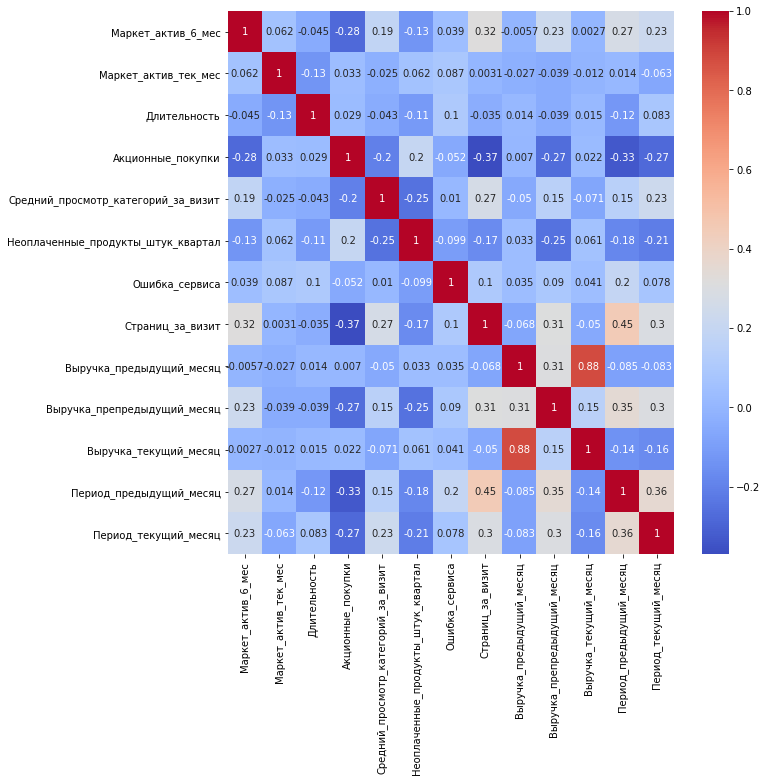

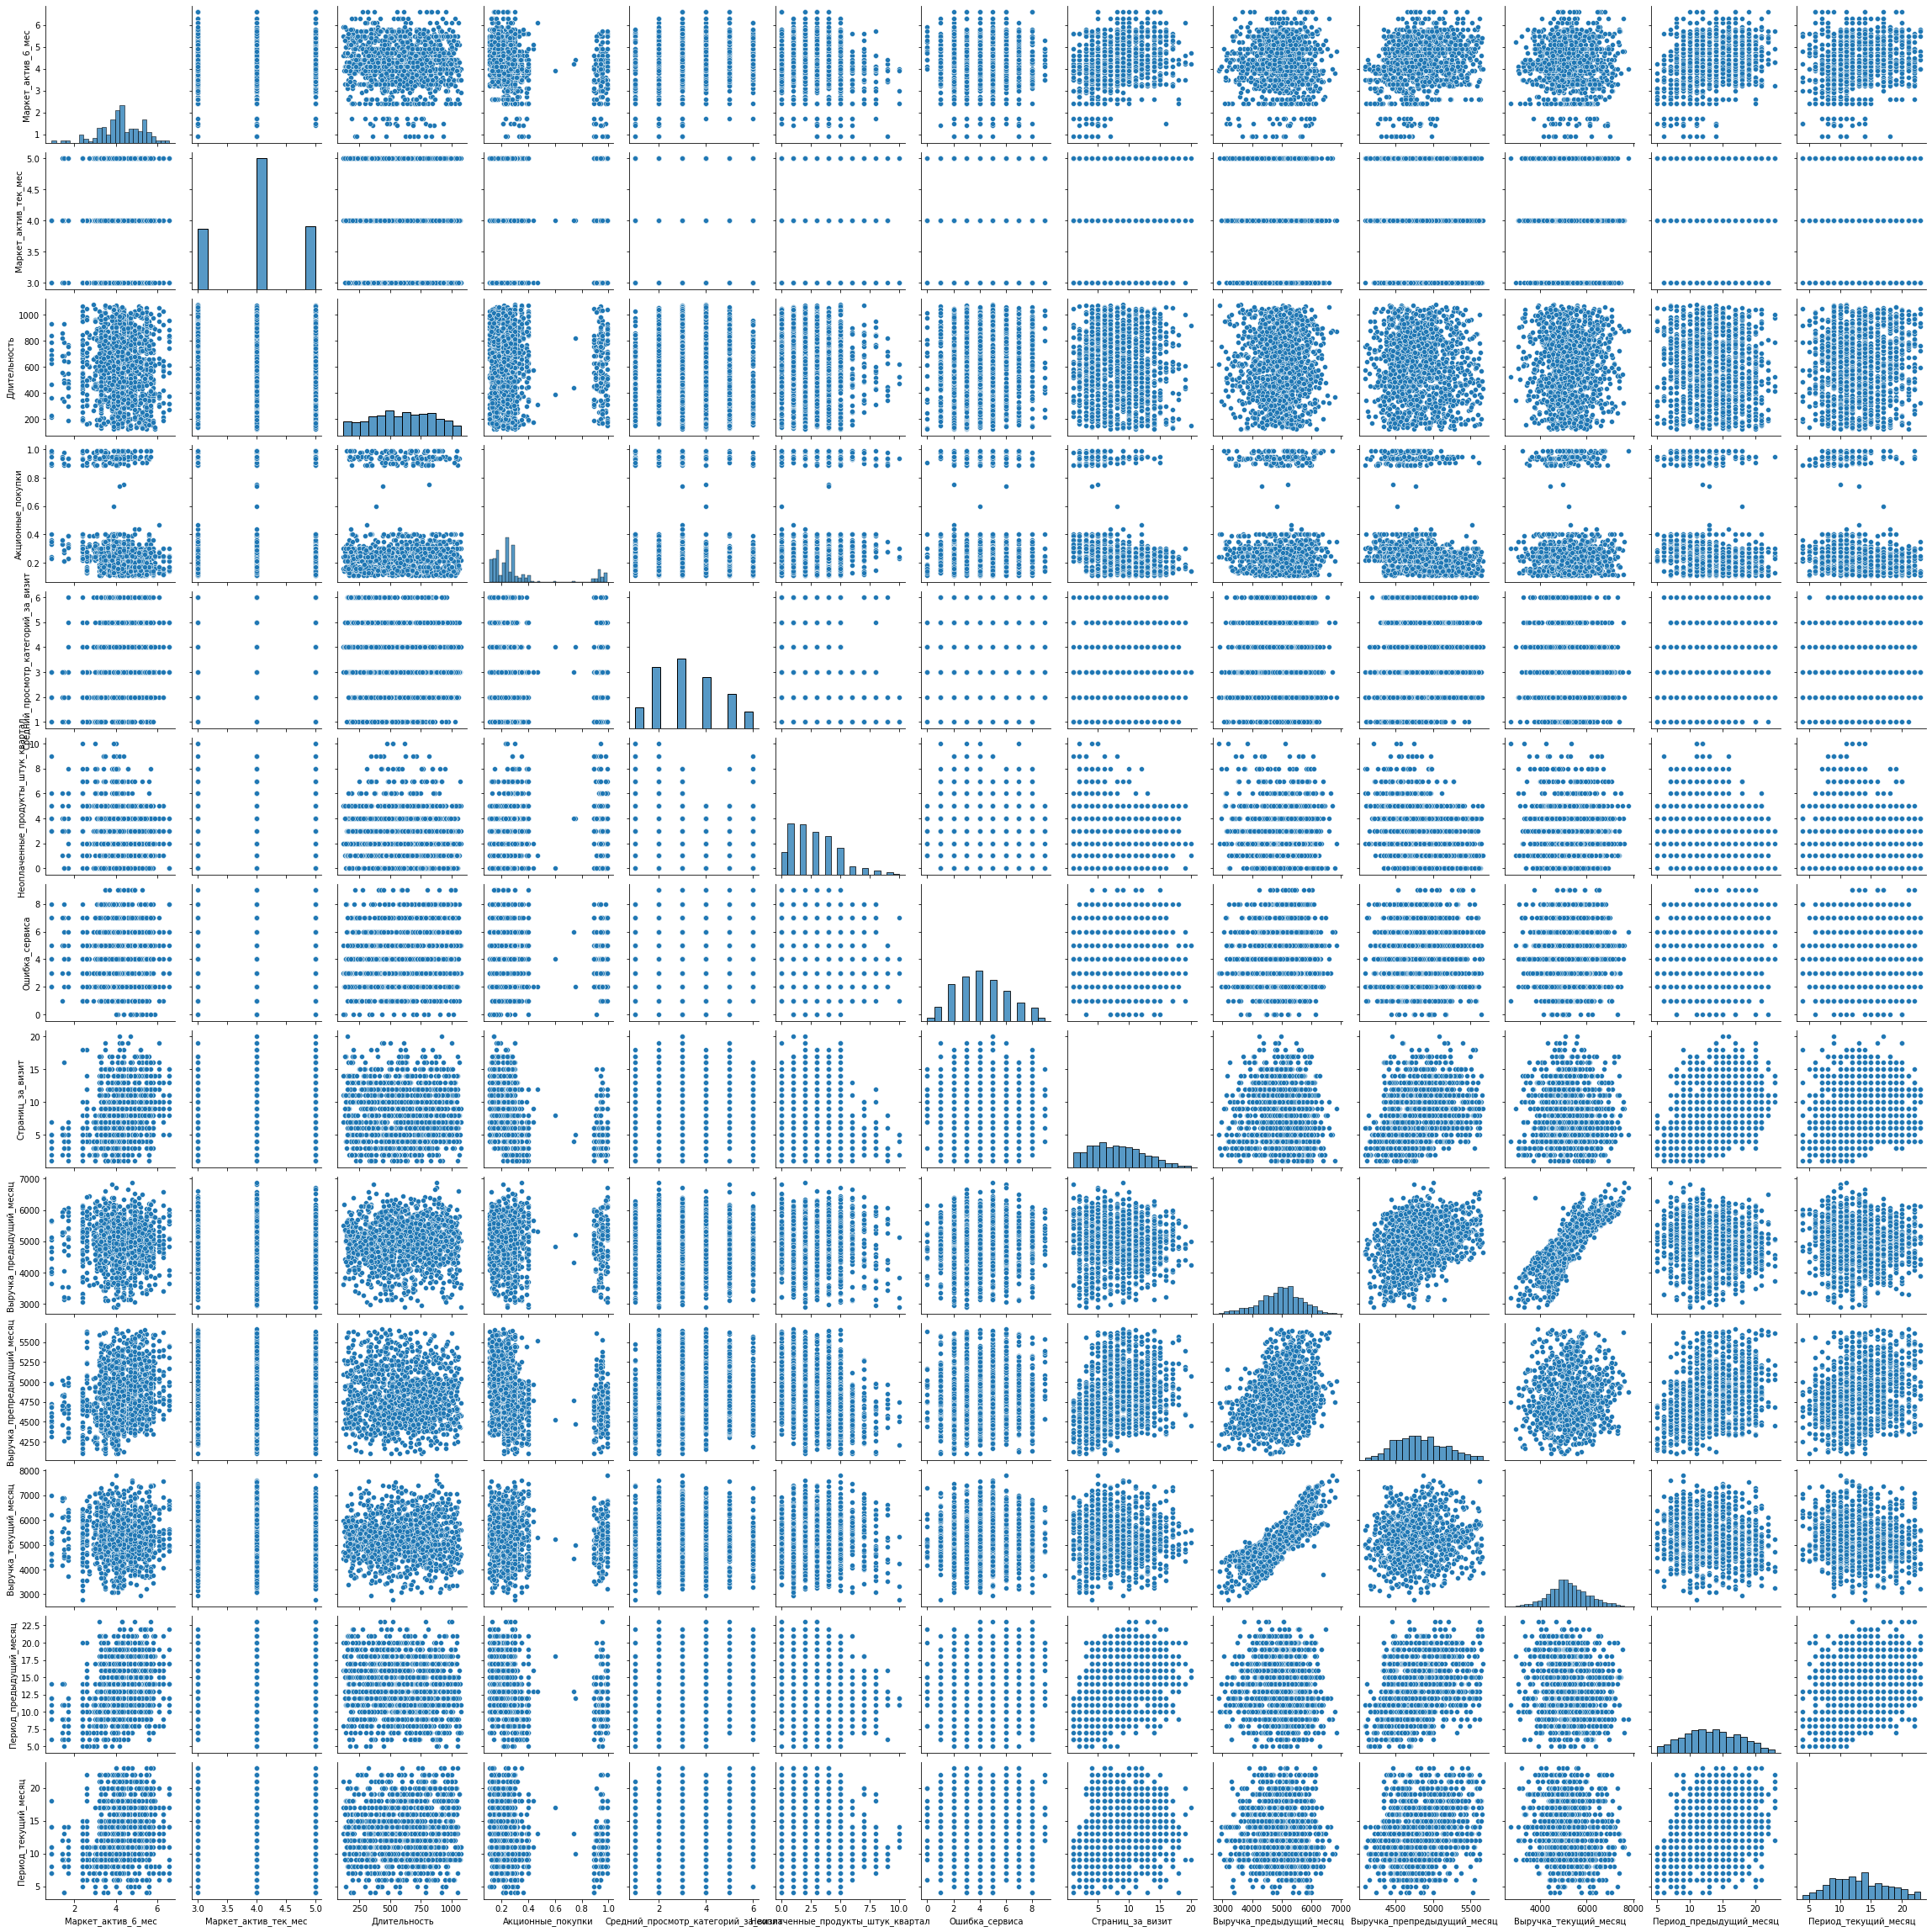

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df.corr(method='spearman'), annot=True, cmap='coolwarm') 
sns.pairplot(df)


Рассчитаем коэффициент инфляции дисперсии (VIF) для определения возможной мультиколлинеарности:

In [13]:
X = df.copy()
X = X.drop(columns=df1.select_dtypes(include='object').columns)
X = add_constant(X) 
ds=pd.Series([variance_inflation_factor(X.values, i)   
               for i in range(X.shape[1])],   
              index=X.columns)  
print(round(ds, 2))

const                                  352.80
Маркет_актив_6_мес                       1.22
Маркет_актив_тек_мес                     1.04
Длительность                             1.10
Акционные_покупки                        1.19
Средний_просмотр_категорий_за_визит      1.18
Неоплаченные_продукты_штук_квартал       1.20
Ошибка_сервиса                           1.08
Страниц_за_визит                         1.42
Выручка_предыдущий_месяц                 4.24
Выручка_препредыдущий_месяц              1.61
Выручка_текущий_месяц                    3.87
Период_предыдущий_месяц                  1.53
Период_текущий_месяц                     1.32
dtype: float64


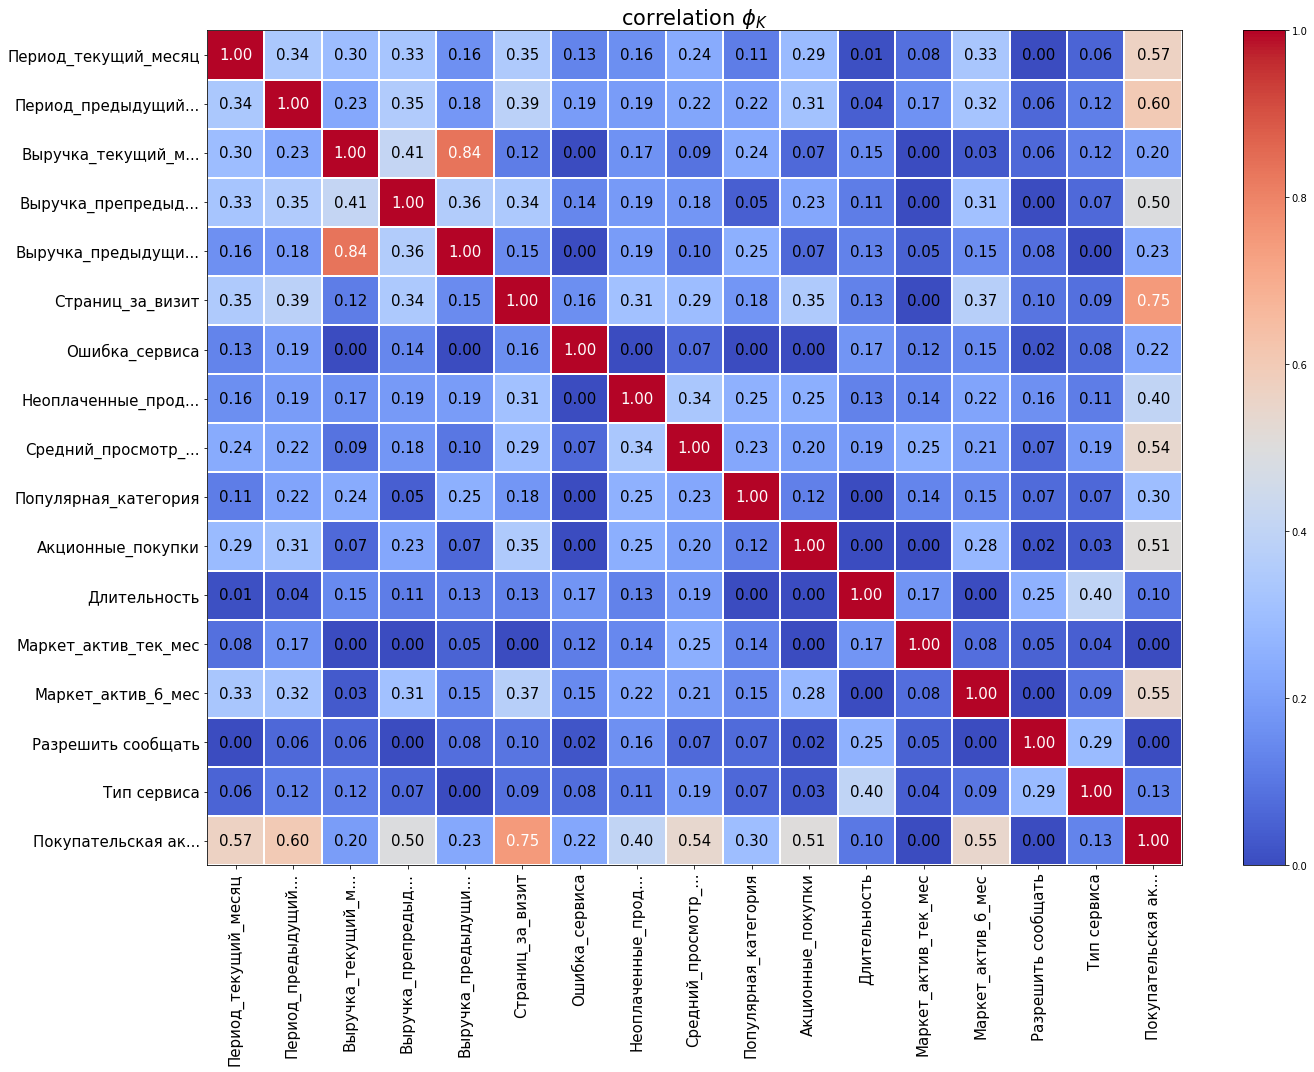

In [14]:
interval_cols = ['Маркет_актив_6_мес', 'Длительность', 'Акционные_покупки',\
                 'Выручка_предыдущий_месяц', 'Выручка_препредыдущий_месяц', 'Выручка_текущий_месяц']

# считаем корреляции на тренировочной выборке
phik_overview = phik_matrix(df, interval_cols=interval_cols) 

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='coolwarm',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)  

### Промежуточный вывод:

По матрице корреляции, тепловой карте и коэффициентам инфляции дисперсии видна умеренная мультиколлинеарность параметров `Выручка_предыдущий_месяц` и `Выручка_текущий_месяц`. 

В ходе исследования матрицы корреляции `phik_matrix()` утечка данных не обнаружена.

В ходе промежуточного исследования моделей через пайплан было выявлено незначительное увеличение метрики `roc_auc` при удалении мультиколлинеарности. Поэтому, при дальнейшей работе с данными при разбиении на выборки будем удалять и столбец `Выручка_предыдущий_месяц`. 

## 6. Использование пайплайнов

Применим все изученные модели, для этого используем пайплайны.

Подготовим данные с помощью `ColumnTransformer`. Для кодирования категориальных признаков необходимо использовать как минимум два кодировщика, для масштабирования количественных — как минимум два скейлера.

Необходимо обучить четыре модели: `KNeighborsClassifier()`, `DecisionTreeClassifier()`, `LogisticRegression()` и  `SVC()`. 

Для каждой из них подберём как минимум один гиперпараметр, а также выберем подходящую для подбора метрику. 

Также устраним дисбаланс классов.

Выберем лучшую модель, используя метрику `roc_auc`. 

In [15]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Покупательская активность', 'Выручка_предыдущий_месяц'], axis=1),
    df['Покупательская активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df['Покупательская активность']
)

ohe_columns = ['Тип сервиса', 'Разрешить сообщать', 'Популярная_категория']

num_columns = list(X_train.select_dtypes(include=['int', 'float']).columns)

In [16]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False))
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
) 

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 6),
        'models__max_features': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 3),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, kernel='poly', probability=True)],
        'models__degree': range(1, 3),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
]

grid_search = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    #random_state=RANDOM_STATE,
    n_jobs=-1
)

sampler = SMOTENC(categorical_features=ohe_columns, random_state=42, k_neighbors=50)
X_train_sampled, y_train_sampled = sampler.fit_resample(X_train, y_train) 

grid_search.fit(X_train_sampled, y_train_sampled)

print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', round(grid_search.best_score_, 2))

y_test_pred_proba = grid_search.predict_proba(X_test)[:,1]
y_test_pred = grid_search.predict(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test, y_test_pred_proba), 2)}')

f1 = f1_score(y_test, y_test_pred, average='macro')
print('F1-score =', round(f1,2))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['Тип сервиса',
                                                   'Разрешить сообщать',
                                                   'Популярная_категория']),
                                                 ('num', MinMaxScaler(),
                                                  ['Маркет_актив

### Промежуточный вывод:

Лучшей моделью является `LogisticRegression()` с параметрами `C=3, penalty='l1', random_state=42, solver='liblinear'`.

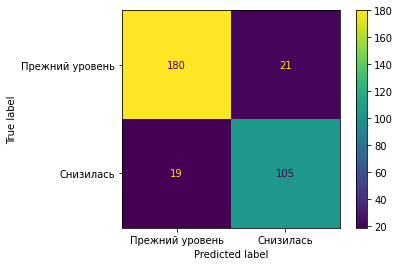

In [17]:
ConfusionMatrixDisplay.from_estimator(grid_search, X_test, y_test)
plt.show()

In [18]:
X_train_p = pd.DataFrame(
    data_preprocessor.fit_transform(X_train_sampled),
    columns=data_preprocessor.get_feature_names_out()
)

X_test_p = pd.DataFrame(
    data_preprocessor.transform(X_test),
    columns=data_preprocessor.get_feature_names_out()
)
selector = SelectKBest(f_classif, k=16)
selector.fit(X_train_p, y_train_sampled)

best_model = grid_search.best_params_['models']
best_model.fit(X_train_p, y_train_sampled)


LogisticRegression(C=3, penalty='l1', random_state=42, solver='liblinear')

## 7. Анализ важности признаков

Оценим важность признаков для лучшей модели и построим графики важности с помощью метода SHAP.

---

### График общей значимости признаков:

In [19]:
X_train_ = grid_search.best_estimator_.named_steps.preprocessor.fit_transform(X_train)
model_shap = KNeighborsClassifier(n_neighbors=5).fit(X_train_, y_train)
X_test_ = grid_search.best_estimator_.named_steps.preprocessor.transform(X_test)
explainer = shap.Explainer(model_shap.predict_proba, X_train_)
shap_values = explainer(X_test_)

PermutationExplainer explainer: 326it [01:12,  4.15it/s]                         


Количество признаков в SHAP: 19
Количество признаков в данных: 19


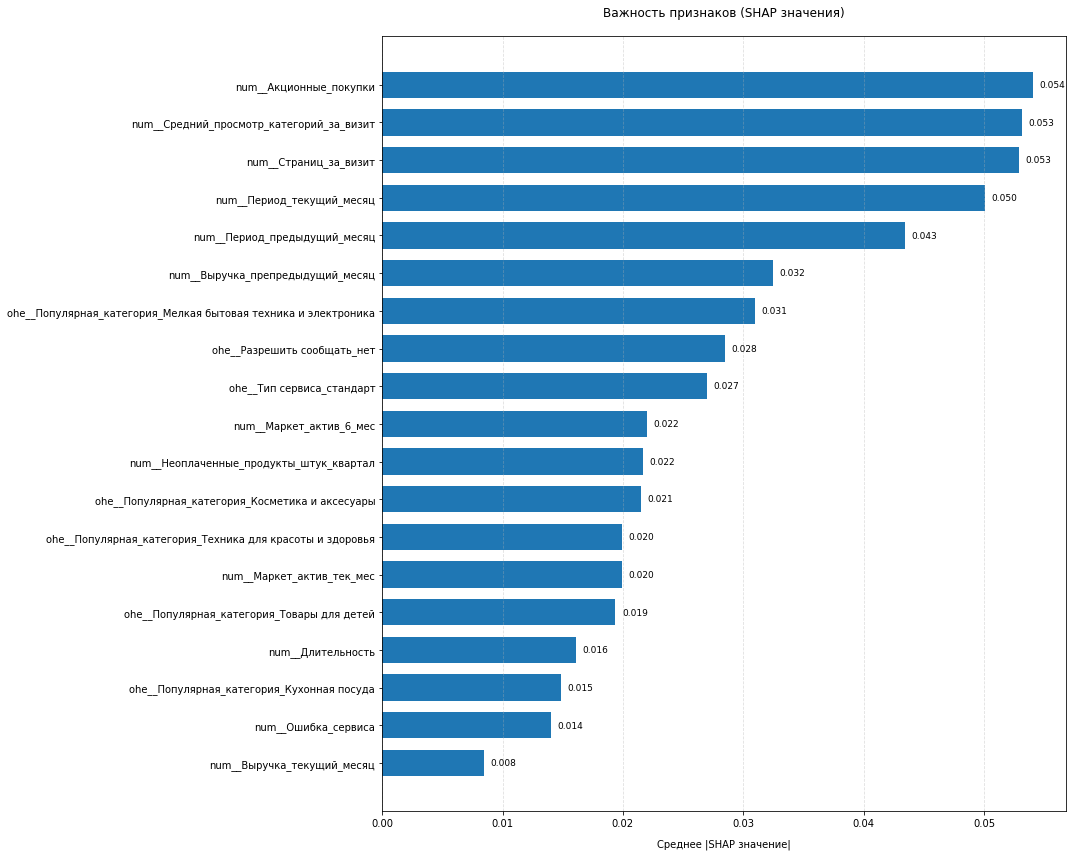

In [20]:
# Берем абсолютные значения и усредняем по всем наблюдениям и классам
shap_importance = np.abs(shap_values.values).mean(axis=(0,2))

# Проверяем соответствие количества признаков
print(f"Количество признаков в SHAP: {len(shap_importance)}")
print(f"Количество признаков в данных: {len(X_test_p.columns)}")

# 2. Создаем DataFrame
shap_df = pd.DataFrame({
    'features': X_test_p.columns,
    'importance': shap_importance
})

# 3. Сортируем и фильтруем топ-30
shap_df = shap_df.sort_values('importance', ascending=False).head(30)

# 4. Строим график
plt.figure(figsize=(15, 12))
bars = plt.barh(shap_df['features'], shap_df['importance'], height=0.7)

# 5. Добавляем подписи
for bar in bars:
    width = bar.get_width()
    plt.text(width + max(shap_df['importance'])*0.01,
             bar.get_y() + bar.get_height()/2,
             f'{width:.3f}',
             va='center',
             fontsize=9)

plt.gca().invert_yaxis()
plt.title("Важность признаков (SHAP значения)", pad=20)
plt.xlabel("Среднее |SHAP значение|", labelpad=10)
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

### График вклада признаков в каждое предсказание модели:

Исходная размерность SHAP: (325, 19, 2)


/opt/conda/lib/python3.9/site-packages/shap/plots/_beeswarm.py:497: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_yticks(range(len(feature_inds)), list(reversed(yticklabels)), fontsize=13)
/tmp/ipykernel_393/4201837186.py:34: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


Ошибка beeswarm: set_ticks() got an unexpected keyword argument 'fontsize'


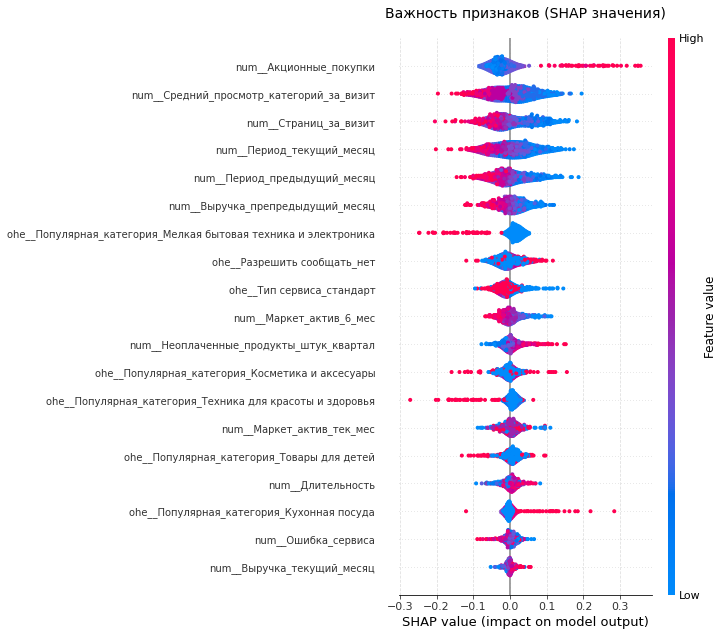

In [21]:
# 1. Проверка и преобразование SHAP значений
print(f"Исходная размерность SHAP: {shap_values.values.shape}")

# Выбираем SHAP значения для одного класса (последняя размерность)
shap_values_2d = np.array(shap_values.values)[..., -1]  # Берем последний класс

# 2. Создание Explanation объекта
try:
    explanation = shap.Explanation(
        values=shap_values_2d,
        base_values=np.array(shap_values.base_values)[..., -1],
        data=X_test_p.values,
        feature_names=X_test_p.columns.tolist()
    )
except Exception as e:
    print(f"Ошибка создания Explanation: {e}")
    # Альтернативный вариант для старых версий SHAP
    explanation = shap_values_2d

# 3. Построение графика с обработкой ошибок
plt.figure(figsize=(12, 14))

try:
    # Основной вариант с beeswarm
    shap.plots.beeswarm(
        explanation,
        max_display=30,
        show=False,
        color_bar=False
    )
except Exception as e:
    print(f"Ошибка beeswarm: {e}")
    # Запасной вариант с violin plot
    shap.summary_plot(
        shap_values_2d,
        features=X_test_p.values,
        feature_names=X_test_p.columns,
        plot_type='violin',
        max_display=30,
        show=False
    )

# 4. Настройка отображения
ax = plt.gca()

# Проверка наличия подписей
if ax.get_yticklabels():
    ax.set_yticklabels(
        [t.get_text() for t in ax.get_yticklabels()],
        fontsize=10,
        ha='right'
    )

plt.subplots_adjust(left=0.4, right=0.95, top=0.95, bottom=0.1)
plt.title("Важность признаков (SHAP значения)", pad=20, fontsize=14)
ax.grid(axis='x', linestyle='--', alpha=0.4)

plt.show()

### Диаграмма индивидуальных SHAP-значений каждого наблюдения в датасете: 

Выделим объекты FP:

In [22]:
X_test_p_df = X_test_p.copy()
X_test_p_df['y_tester'] = y_test_pred.tolist()
X_test_p_df['predict_proba'] = best_model.predict_proba(X_test_p)[:,1]
X_test_p_df['y_true'] = y_test.tolist()


X_test_p_df[(X_test_p_df['y_tester']=='Снизилась')&(X_test_p_df['y_true']== 'Прежний уровень')] \
.sort_values(by='predict_proba', ascending=False)

ohe__Тип сервиса_стандарт  ohe__Разрешить сообщать_нет  \
319                        1.0                          0.0   
34                         1.0                          0.0   
269                        0.0                          0.0   
116                        1.0                          0.0   
323                        1.0                          1.0   
72                         1.0                          0.0   
192                        1.0                          0.0   
71                         1.0                          1.0   
108                        1.0                          0.0   
93                         1.0                          0.0   
0                          1.0                          0.0   
241                        1.0                          0.0   
283                        0.0                          0.0   
139                        1.0                          0.0   
89                         1.0                          1.0   
37                         1.0                          0.0   
175                        0.0                          0.0   
306                        1.0                          0.0   
258                        1.0                          1.0   
228                        1.0                          0.0   
176                        1.0                          0.0   

     ohe__Популярная_категория_Косметика и аксесуары  \
319                                              0.0   
34                                               0.0   
269                                              0.0   
116                                              0.0   
323                                              1.0   
72                                               0.0   
192                                              1.0   
71                                               1.0   
108                                              0.0   
93                                               0.0   
0                                                0.0   
241                                              1.0   
283                                              1.0   
139                                              0.0   
89                                               0.0   
37                                               1.0   
175                                              0.0   
306                                              1.0   
258                                              0.0   
228                                              0.0   
176                                              0.0   

     ohe__Популярная_категория_Кухонная посуда  \
319                                        0.0   
34                                         1.0   
269                                        1.0   
116                                        0.0   
323                                        0.0   
72                                         1.0   
192                                        0.0   
71                                         0.0   
108                                        0.0   
93                                         1.0   
0                                          0.0   
241                                        0.0   
283                                        0.0   
139                                        0.0   
89                                         0.0   
37                                         0.0   
175                                        0.0   
306                                        0.0   
258                                        0.0   
228                                        1.0   
176                                        0.0   

     ohe__Популярная_категория_Мелкая бытовая техника и электроника  \
319                                                0.0                
34                                                 0.0                
269                                                0.0                


In [23]:
# Получить предобработчик из best_estimator_
preprocessor = grid_search.best_estimator_.named_steps['preprocessor']

# Получить названия признаков
if hasattr(preprocessor, 'transformers_'):
    feature_names = []
    for name, transformer, columns in preprocessor.transformers_:
        if transformer == 'drop':
            continue
        if hasattr(transformer, 'get_feature_names_out'):
            feature_names.extend(transformer.get_feature_names_out(columns))
        elif hasattr(transformer, 'get_feature_names'):
            feature_names.extend(transformer.get_feature_names(columns))
        else:
            feature_names.extend(columns)
else:
    if hasattr(preprocessor, 'get_feature_names_out'):
        feature_names = list(preprocessor.get_feature_names_out())
    else:
        feature_names = [f"Feature_{i}" for i in range(X_train.shape[1])]


Объяснение для наблюдения 319:
Тип: <class 'shap._explanation.Explanation'>
Форма: (19,)


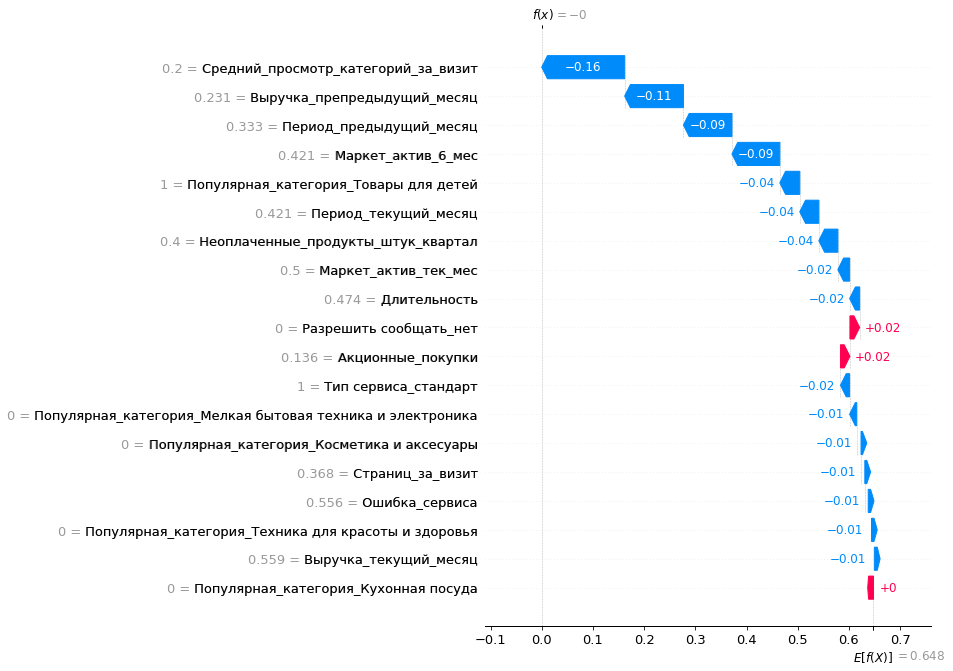


Объяснение для наблюдения 176:
Тип: <class 'shap._explanation.Explanation'>
Форма: (19,)


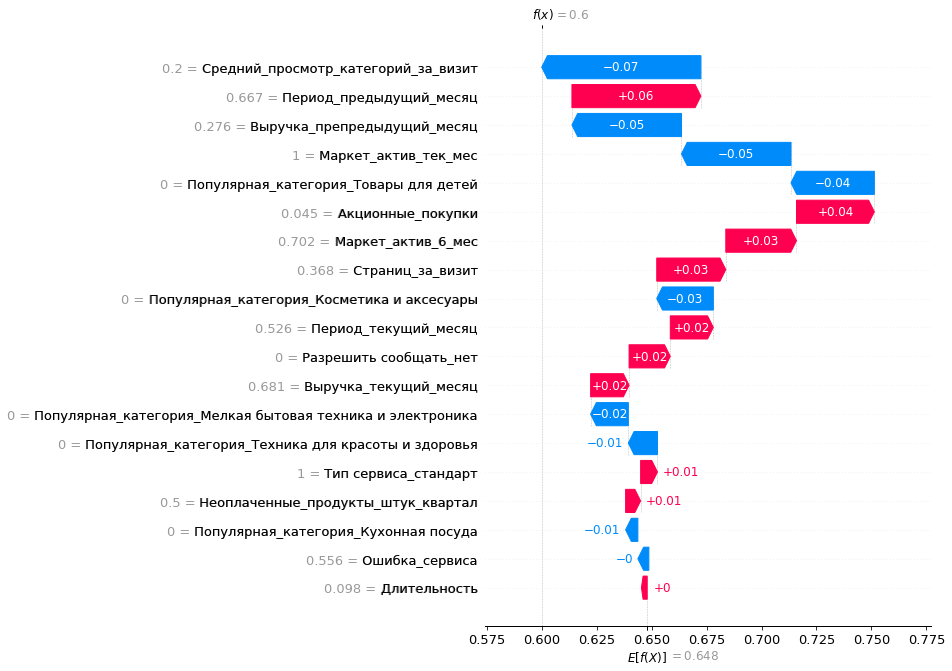

In [24]:
indices = [319, 176]
class_idx = 0  # индекс класса, для которого делается объяснение

for idx in indices:
    # Получаем SHAP-значения для текущего наблюдения
    shap_obj = shap_values[idx]
    
    # Обеспечиваем, что data — одномерный массив признаков
    data_point = shap_obj.data
    if hasattr(data_point, 'shape'):
        if data_point.shape[0] > 1:
            data_point = data_point.flatten()
        elif data_point.shape[0] == 1:
            data_point = data_point.squeeze()
    
    # Получаем базовое значение для выбранного класса
    base_value = shap_obj.base_values[class_idx]
    
    # Создаем Explanation для выбранного класса
    explanation = shap.Explanation(
        values=shap_obj.values[:, class_idx],  # SHAP-значения для этого класса
        base_values=base_value,
        data=data_point,
        feature_names=feature_names
    )
    
    print(f"\nОбъяснение для наблюдения {idx}:")
    print(f"Тип: {type(explanation)}")
    print(f"Форма: {explanation.values.shape}")
    
    # Построение графика
    shap.plots.waterfall(explanation, max_display=30)

Посмотрим ошибки класса FN:

In [25]:
X_test_p_df[(X_test_p_df['y_tester']=='Прежний уровень')&(X_test_p_df['y_true']== 'Снизилась')] \
.sort_values(by='predict_proba', ascending=False)

ohe__Тип сервиса_стандарт  ohe__Разрешить сообщать_нет  \
136                        1.0                          0.0   
141                        0.0                          0.0   
60                         0.0                          0.0   
67                         0.0                          0.0   
142                        1.0                          1.0   
316                        1.0                          0.0   
255                        1.0                          1.0   
152                        0.0                          0.0   
118                        0.0                          0.0   
288                        0.0                          0.0   
281                        1.0                          0.0   
210                        1.0                          0.0   
57                         0.0                          0.0   
83                         0.0                          0.0   
12                         1.0                          0.0   
154                        1.0                          1.0   
167                        0.0                          0.0   
201                        1.0                          0.0   
55                         1.0                          1.0   

     ohe__Популярная_категория_Косметика и аксесуары  \
136                                              0.0   
141                                              1.0   
60                                               0.0   
67                                               0.0   
142                                              1.0   
316                                              0.0   
255                                              0.0   
152                                              0.0   
118                                              0.0   
288                                              0.0   
281                                              0.0   
210                                              1.0   
57                                               0.0   
83                                               1.0   
12                                               0.0   
154                                              0.0   
167                                              0.0   
201                                              0.0   
55                                               1.0   

     ohe__Популярная_категория_Кухонная посуда  \
136                                        0.0   
141                                        0.0   
60                                         0.0   
67                                         0.0   
142                                        0.0   
316                                        0.0   
255                                        0.0   
152                                        0.0   
118                                        0.0   
288                                        0.0   
281                                        0.0   
210                                        0.0   
57                                         0.0   
83                                         0.0   
12                                         0.0   
154                                        0.0   
167                                        0.0   
201                                        0.0   
55                                         0.0   

     ohe__Популярная_категория_Мелкая бытовая техника и электроника  \
136                                                0.0                
141                                                0.0                
60                                                 0.0                
67                                                 0.0                
142                                                0.0                
316                                                0.0                
255                                                0.0                
152                                                1.0


Объяснение для наблюдения 136:
Тип: <class 'shap._explanation.Explanation'>
Форма: (19,)


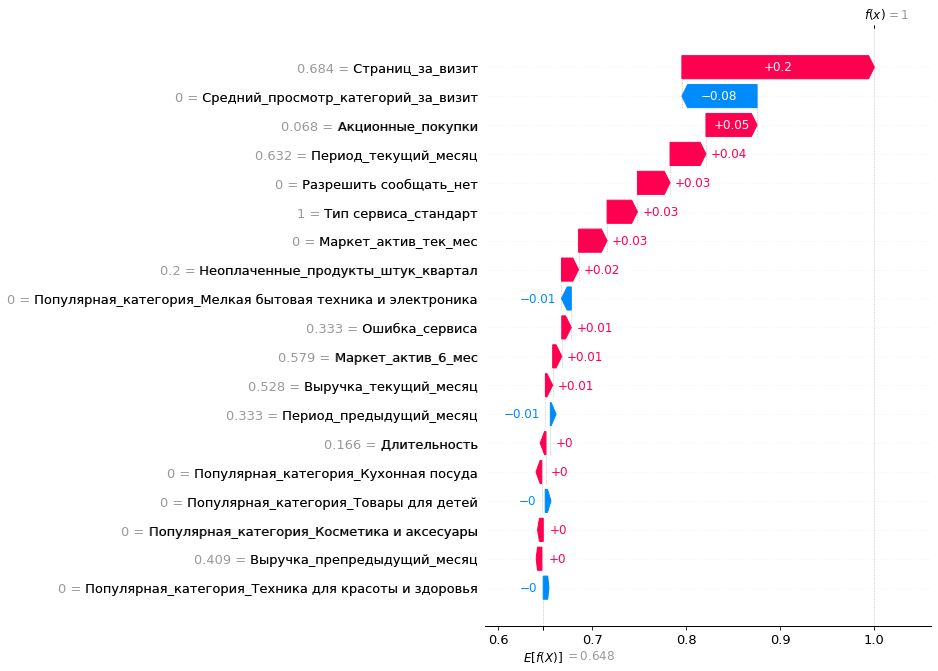


Объяснение для наблюдения 55:
Тип: <class 'shap._explanation.Explanation'>
Форма: (19,)


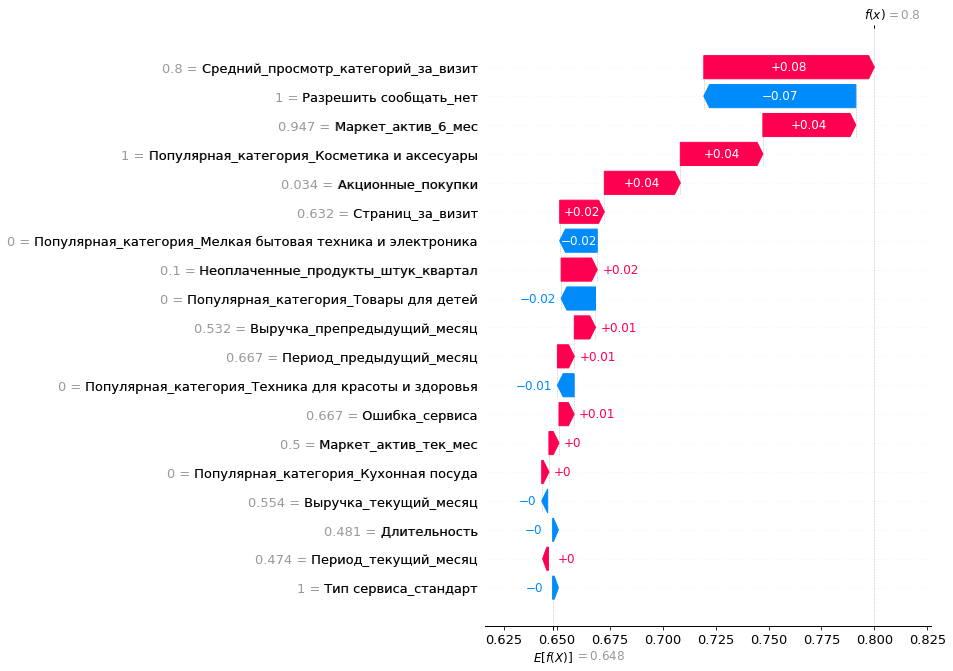

In [26]:
indices = [136, 55]
class_idx = 0

# Создаем объяснение для одного примера
explanation = shap.Explanation(
    values=shap_values.values[idx],
    base_values=shap_values.base_values,
    data=X_test_[idx],
    feature_names=feature_names
)

for idx in indices:
    shap_obj = shap_values[idx]
    
    # Обеспечиваем, что data — одномерный массив признаков
    data_point = shap_obj.data
    if hasattr(data_point, 'shape'):
        if data_point.shape[0] > 1:
            data_point = data_point.flatten()
        elif data_point.shape[0] == 1:
            data_point = data_point.squeeze()
    
    # Получаем базовое значение для выбранного класса
    base_value = shap_obj.base_values[class_idx]
    
    # Создаем Explanation для выбранного класса
    explanation = shap.Explanation(
        values=shap_obj.values[:, class_idx],  # SHAP-значения для этого класса
        base_values=base_value,
        data=data_point,
        feature_names=feature_names
    )
    
    print(f"\nОбъяснение для наблюдения {idx}:")
    print(f"Тип: {type(explanation)}")
    print(f"Форма: {explanation.values.shape}")
    
    # Построение графика
    shap.plots.waterfall(explanation, max_display=30)

### Промежуточные выводы:

Менее всего значимы для модели признаки:

* Выручка за текущий месяц обсолютно не влияет на модель (вес признака 0,0);
* количество маркетинговых коммуникаций, категории товара, выручка за прошлые месяцы, время с момента регистрации, ошибки сервиса и рассылка покупателям дополнительных предложений о товаре влияют на работу модели незначительно (вес признаков менее 0,2);

Более всего значимы для модели признаки:

* Подавляющее влияние на модель оказывает количество просмотренных категорий товаров за визит (вес признака 0,69);
* Также немаловажную роль играют количество просмотренных страниц за визит и доля покупок товаров по акции (вес более 0,5).

Также необходимо отметить, что покупательская активность не снижается, если подеррживаются на высоком уровне количество просмотренных категорий и страниц за визит. В то же время лояльность сохранят те, кто был активен в предыдущие месяцы. Немаловажен и тот факт, что **высокая доля купленных товаров по акции и большое количество неоплаченных товаров в корзине наоборот увеличивают вероятность снижения покупательской активности.** 

Из всего вышеперечисленного можно сделать вывод, что необходимо улучшать алгоритмы, отвечающие за предложение похожих товаров, а также товаров из смежных категорий. Логично, что при большом выборе и правильном подборе нужных товаров повышается вероятность покупки. А вот большое количество акций ситуацию не спасают, а наоборот вредят покупательской активности. Возможно, клиенты относятся настороженно к акциям и скидкам, предполагая, что качество и полезность таких товаров низкое, если их не берут за свою цену.

Также справедливым будет такое предположение: если активно заинтересовывать клиентов новыми товарами и категориями, их активность будет помесячно высокой. Модель логично относит таких покупателей с высокой долей вероятности к тем, чья покупательская активность не снизится.

## 8. Сегментация покупателей

Выполним сегментацию покупателей, используя результаты моделирования и данные о прибыльности покупателей. Выберем группу покупателей и предложим варианты увеличения её покупательской активности: 

* Проведём графическое и аналитическое исследование группы покупателей;
* сделаем предложения по работе с сегментом для увеличения покупательской активности.

In [27]:
X_test_p_df.index = X_test.index
df4 = df4.set_index('id') 
X_test_p_df = X_test_p_df.join(df4)
X_test_p_df

ohe__Тип сервиса_стандарт  ohe__Разрешить сообщать_нет  \
id                                                               
216446                        1.0                          0.0   
215469                        0.0                          0.0   
216301                        0.0                          0.0   
215713                        1.0                          0.0   
215500                        1.0                          0.0   
...                           ...                          ...   
215568                        0.0                          0.0   
216119                        0.0                          0.0   
215504                        1.0                          0.0   
216547                        1.0                          1.0   
215398                        0.0                          0.0   

        ohe__Популярная_категория_Косметика и аксесуары  \
id                                                        
216446                                              0.0   
215469                                              0.0   
216301                                              1.0   
215713                                              0.0   
215500                                              1.0   
...                                                 ...   
215568                                              0.0   
216119                                              1.0   
215504                                              0.0   
216547                                              1.0   
215398                                              0.0   

        ohe__Популярная_категория_Кухонная посуда  \
id                                                  
216446                                        0.0   
215469                                        0.0   
216301                                        0.0   
215713                                        0.0   
215500                                        0.0   
...                                           ...   
215568                                        0.0   
216119                                        0.0   
215504                                        0.0   
216547                                        0.0   
215398                                        0.0   

        ohe__Популярная_категория_Мелкая бытовая техника и электроника  \
id                                                                       
216446                                                0.0                
215469                                                0.0                
216301                                                0.0                
215713                                                0.0                
215500                                                0.0                
...                                                   ...                
215568                                                0.0                
216119                                                0.0                
215504                                                0.0                
216547                                                0.0                
215398                                                1.0                

        ohe__Популярная_категория_Техника для красоты и здоровья  \
id                                                                 
216446                                                1.0          
215469                                                0.0          
216301                                                0.0          
215713                                                0.0          
215500                                                0.0          
...                                                   ...          
215568                                                0.0          
216119                                                0.0          
215504                                          

Тестовая выборка:
Диаграммы рассеяния значений прибыли:


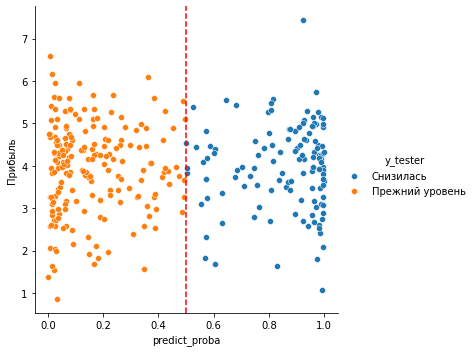

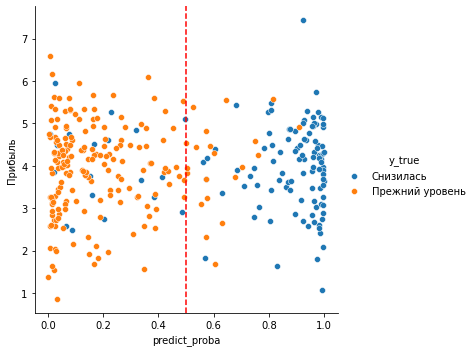

In [28]:
print('Тестовая выборка:')
print('Диаграммы рассеяния значений прибыли:')
for row in ['y_tester', 'y_true']:  
    g = sns.FacetGrid(data=X_test_p_df, hue=row, height=5, aspect=1, hue_order=['Снизилась', 'Прежний уровень'])
    g.map(sns.scatterplot, 'predict_proba', 'Прибыль') 
    g.add_legend()
    plt.axvline(x=0.5, linestyle='--', color='red')
    plt.show()


Отберём всех клиентов из тестовой выборки, по которым модель предполагает, что они снизят покупательскую активность:

In [29]:
df_segm = df.join(X_test_p_df[['y_tester', 'predict_proba', 'y_true', 'Прибыль']], how = 'inner')
df_segm = df_segm.query('y_tester == "Снизилась"')
df_segm = df_segm.drop(columns='Покупательская активность')
df_segm

Тип сервиса Разрешить сообщать  Маркет_актив_6_мес  \
id                                                          
215349     премиум                 да                 4.4   
215351    стандарт                 да                 3.2   
215353    стандарт                 да                 3.3   
215354    стандарт                 да                 5.1   
215356    стандарт                 да                 4.2   
...            ...                ...                 ...   
216565    стандарт                 да                 5.2   
216595    стандарт                 да                 4.2   
216607    стандарт                 да                 3.3   
216626     премиум                 да                 3.9   
216636     премиум                 да                 2.4   

        Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
id                                                              
215349                     4           819               0.75   
215351                     5           896               0.99   
215353                     4           762               0.26   
215354                     3           431               0.23   
215356                     4           192               0.14   
...                      ...           ...                ...   
216565                     5           638               0.15   
216595                     4           753               0.94   
216607                     4           575               0.23   
216626                     4           488               0.32   
216636                     4           996               0.23   

         Популярная_категория  Средний_просмотр_категорий_за_визит  \
id                                                                   
215349       Товары для детей                                    4   
215351       Товары для детей                                    5   
215353      Домашний текстиль                                    4   
215354  Косметика и аксесуары                                    2   
215356  Косметика и аксесуары                                    2   
...                       ...                                  ...   
216565      Домашний текстиль                                    1   
216595  Косметика и аксесуары                                    6   
216607       Товары для детей                                    2   
216626      Домашний текстиль                                    2   
216636        Кухонная посуда                                    3   

        Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  \
id                                                                             
215349                                   4               2                 5   
215351                                   0               6                 4   
215353                                   1               1                 4   
215354                                   3               7                 2   
215356                                   2               1                 3   
...                                    ...             ...               ...   
216565                                   5               8                 4   
216595                                   2               3                10   
216607                                   4               5                 8   
216626                                   5               3                 8   
216636                                   4               5                 6   

        Выручка_предыдущий_месяц  Выручка_препредыдущий_месяц  \
id                                                              
215349                    5216.0                       4472.0   
215351                    6158.0                       4793.0   
215353                    4738.5                       5124.0   
215354                    5685.0                       4503.0   
215356                   

Маркет_актив_6_мес
count               126.00
mean                  3.73
median                3.90
max                   6.30
min                   0.90

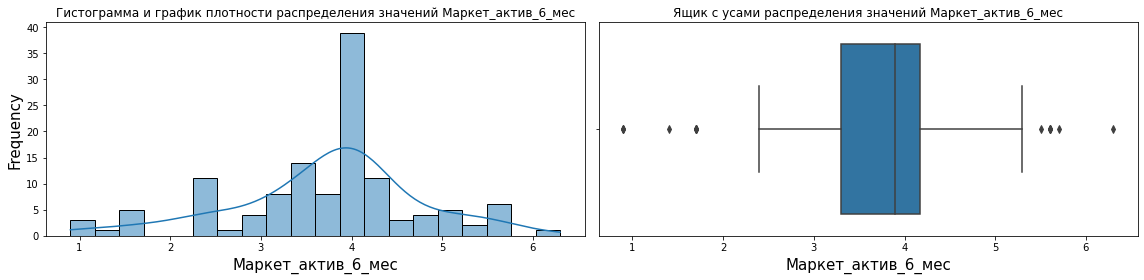

Маркет_актив_тек_мес
count                 126.00
mean                    4.01
median                  4.00
max                     5.00
min                     3.00

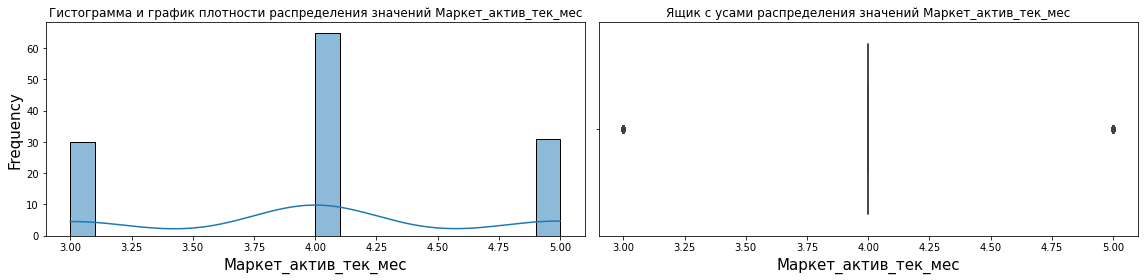

Длительность
count         126.00
mean          611.25
median        602.00
max          1073.00
min           147.00

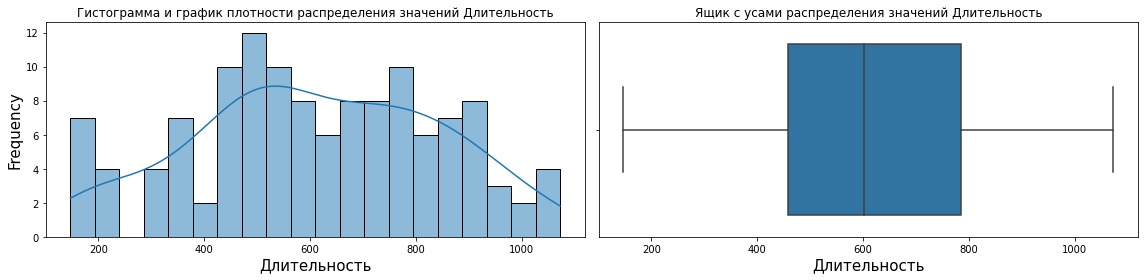

Акционные_покупки
count              126.00
mean                 0.49
median               0.34
max                  0.99
min                  0.12

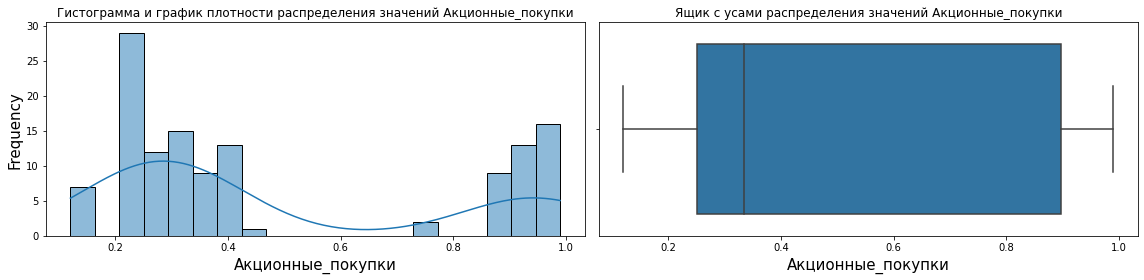

Средний_просмотр_категорий_за_визит
count                                126.00
mean                                   2.52
median                                 2.00
max                                    6.00
min                                    1.00

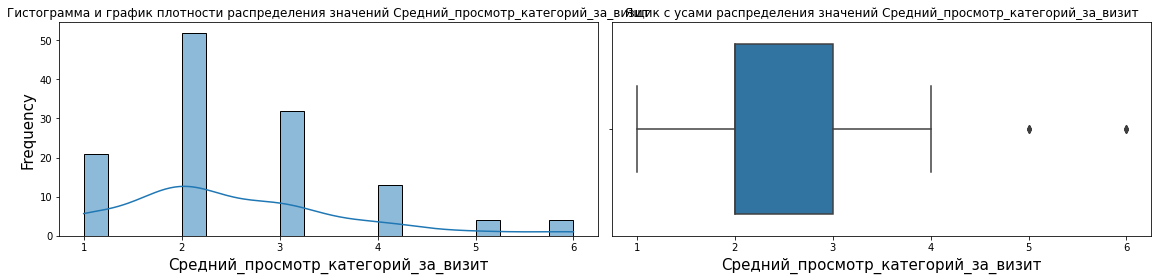

Неоплаченные_продукты_штук_квартал
count                               126.00
mean                                  3.94
median                                4.00
max                                  10.00
min                                   0.00

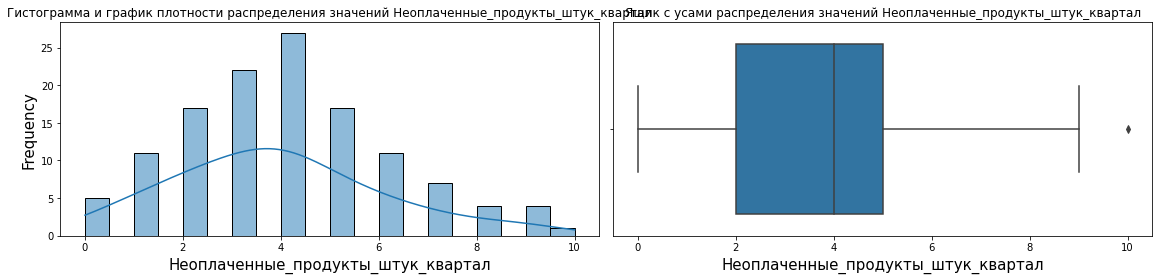

Ошибка_сервиса
count            126.0
mean               3.7
median             3.0
max                8.0
min                0.0

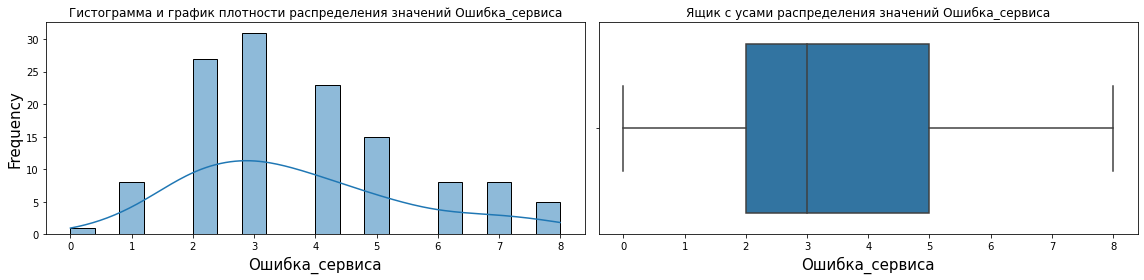

Страниц_за_визит
count             126.00
mean                4.87
median              4.00
max                15.00
min                 1.00

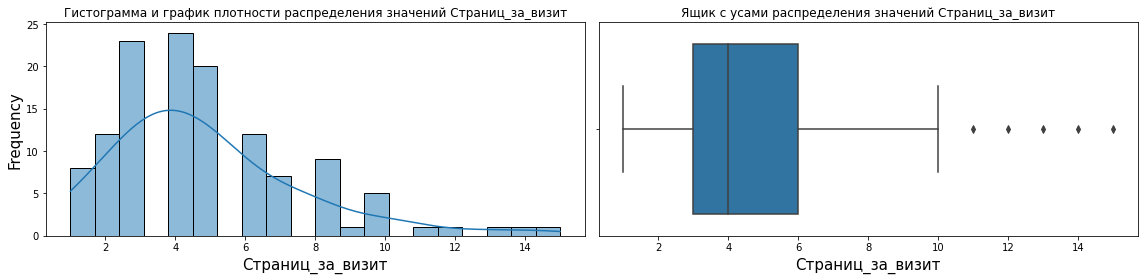

Выручка_предыдущий_месяц
count                     126.00
mean                     4937.62
median                   5037.50
max                      6349.00
min                      2890.00

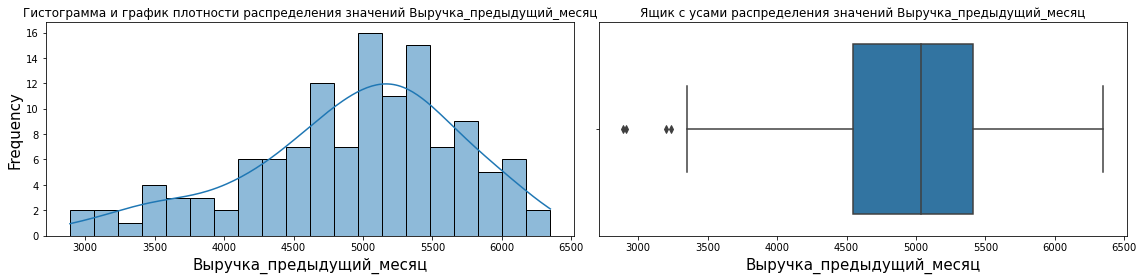

Выручка_препредыдущий_месяц
count                        126.00
mean                        4624.43
median                      4633.00
max                         5269.00
min                         4098.00

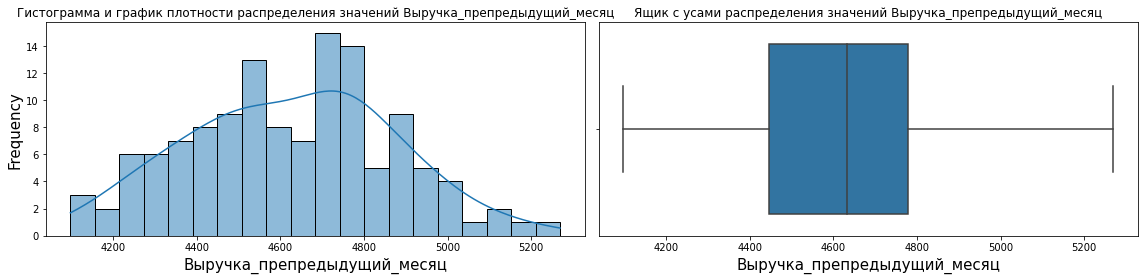

Выручка_текущий_месяц
count                  126.00
mean                  5351.08
median                5449.50
max                   6957.70
min                   3334.60

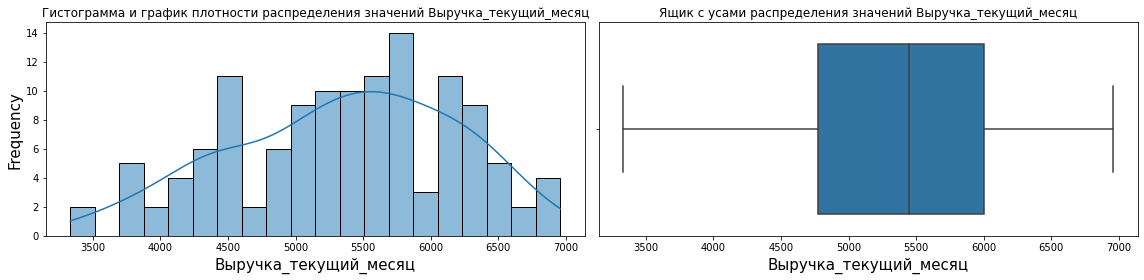

Период_предыдущий_месяц
count                    126.00
mean                      10.37
median                    10.00
max                       18.00
min                        5.00

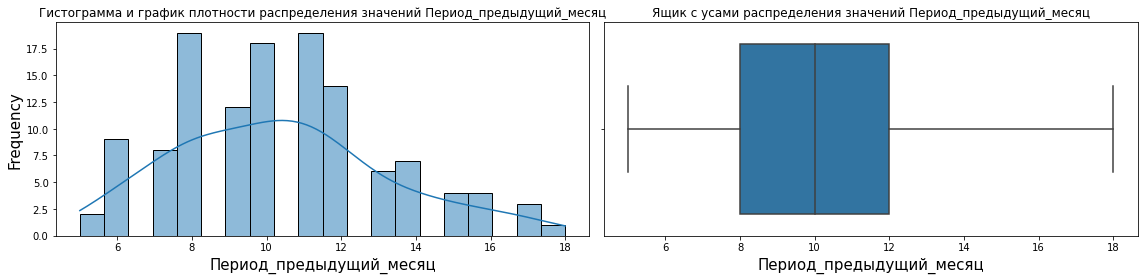

Период_текущий_месяц
count                 126.00
mean                   10.56
median                 10.00
max                    21.00
min                     4.00

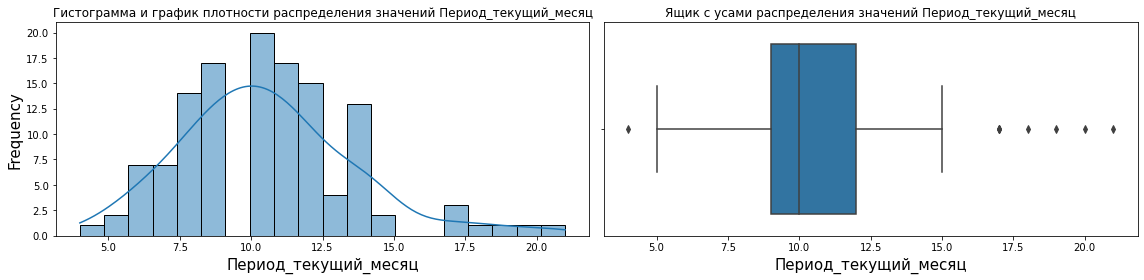

predict_proba
count          126.00
mean             0.85
median           0.92
max              1.00
min              0.50

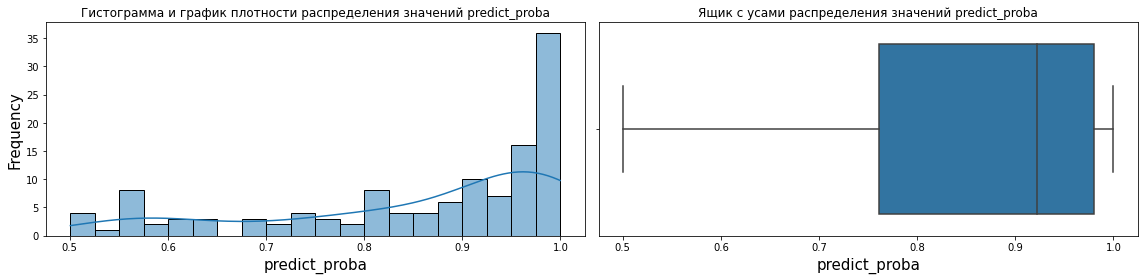

Прибыль
count    126.00
mean       3.99
median     4.11
max        7.43
min        1.06

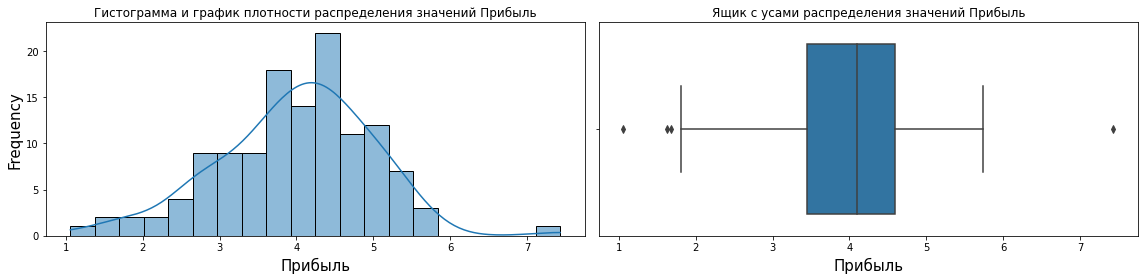

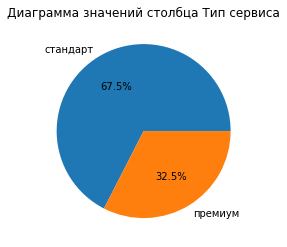

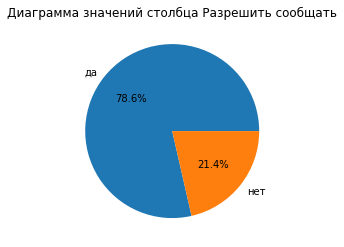

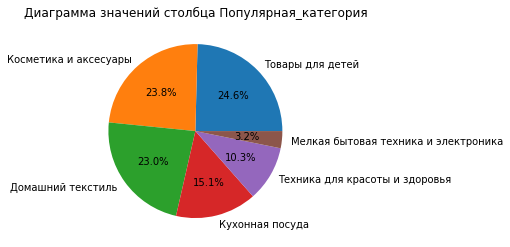

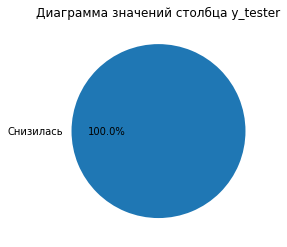

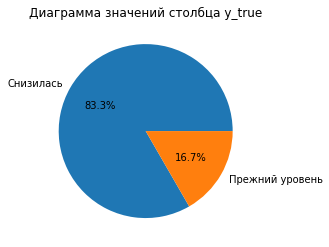

In [30]:
histogram(df_segm)

### Промежуточные выводы:

В ходе анализа выборки покупателей со снижением активности было замечено:

* Среднее количество просмотров категорий за визит снижено на одну по сравнению с общей статистикой;
* Количество неоплаченных продуктов в квартал увеличено на две единицы по сравнению с общей статистикой;
* Количество ошибок сервиса немного ниже общей картины;
* **Количество страниц за визит в два раза ниже;**
* остальные количественные признаки коррелируют с общими данными;
* бОльшая часть клиентов подписана на уведомления, по сравнению с общими данными;
* доля снижения активности увеличена в категориях "косметика и аксессуары", "кухонная посуда", "техника для красотвы и здоровья", "домашний текстиль". Уменьшена в категориях "товары для детей", "мелкая бытовая техника и электроника";
* остальные категориальные признаки коррелируют с общими данными.

### Рекомендации для клиента:

Как уже было сказано выше, прожолжаю настаивать на ранее описанных тезисах:

Покупательская активность не снижается, если подеррживаются на высоком уровне количество просмотренных категорий и страниц за визит. В то же время лояльность сохранят те, кто был активен в предыдущие месяцы. Немаловажен и тот факт, что **высокая доля купленных товаров по акции и большое количество неоплаченных товаров в корзине наоборот увеличивают вероятность снижения покупательской активности.** 

Из всего вышеперечисленного можно сделать вывод, что **необходимо улучшать алгоритмы, отвечающие за предложение похожих товаров, а также товаров из смежных категорий.** Логично, что при большом выборе и правильном подборе нужных товаров повышается вероятность покупки. А вот большое количество акций ситуацию не спасают, а наоборот вредят покупательской активности. Возможно, клиенты относятся настороженно к акциям и скидкам, предполагая, что качество и полезность таких товаров низкое, если их не берут за свою цену.

Также справедливым будет такое предположение: если активно заинтересовывать клиентов новыми товарами и категориями, их активность будет помесячно высокой. Модель логично относит таких покупателей с высокой долей вероятности к тем, чья покупательская активность не снизится.

## 9. Общий вывод

**Описание проекта:** Интернет-магазин «В один клик» продаёт разные товары. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно, возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.
Необходимо разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

**Исходные данные:**
В нашем распоряжении четыре датасета.


Файл `market_file.csv` содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

    id — номер покупателя в корпоративной базе данных.
    Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
    Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
    Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
    Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
    Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
    Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
    Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
    Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
    Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
    Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
    Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
    Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.


Таблица `market_money.csv` содержит данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

    id — номер покупателя в корпоративной базе данных.
    Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
    Выручка — сумма выручки за период.


Таблица `market_time.csv` содержит данные о времени (в минутах), которое покупатель провёл на сайте в течение периода.

    id — номер покупателя в корпоративной базе данных.
    Период — название периода, во время которого зафиксировано общее время.
    минут — значение времени, проведённого на сайте, в минутах.


Таблица `money.csv` содержит данныеи о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

    id — номер покупателя в корпоративной базе данных.
    Прибыль — значение прибыли.
    
**В ходе предобработки исходных данных было сделано:**

* данные проверены на наличие дубликатов и пропусков - отсутствуют;
* исправлены неявные дубликаты и ошибки в данных.

**В ходе исследовательского анализа данных было сделано:**

* были отобраны клиенты с покупательской активностью не менее трёх месяцев;
* каждый датафрейм был проверен на аномальные значения и выбросы. Для кадого признака было сделано предположение о природе происхождения аномалий, во втором датафрейме выброс был заменён медианным значением.

**Корреляционный анализ данных показал:**

По матрице корреляции, тепловой карте и коэффициентам инфляции дисперсии видна умеренная мультиколлинеарность параметров `Выручка_предыдущий_месяц` и `Выручка_текущий_месяц`. 

В ходе исследования матрицы корреляции `phik_matrix()` утечка данных не обнаружена.

В ходе промежуточного исследования моделей через пайплан было выявлено незначительное увеличение метрики `roc_auc` при удалении мультиколлинеарности. Поэтому, при дальнейшей работе с данными при разбиении на выборки будем удалять и столбец `Выручка_предыдущий_месяц`.

**Были обучены четыре модели:** `KNeighborsClassifier()`, `DecisionTreeClassifier()`, `LogisticRegression()` и  `SVC()`. 

Для каждой из них подбраны гиперпараметры, устранён дисбаланс классов. Лучшая модель определена с помощью метрики `roc_auc`. 

**Лучшей моделью является `LogisticRegression()` с параметрами `C=3, penalty='l1', random_state=42, solver='liblinear'`.**

**Оценены важности признаков для лучшей модели и построены графики важности с помощью метода SHAP.**

Менее всего значимы для модели признаки:

* Выручка за текущий месяц обсолютно не влияет на модель (вес признака 0,0);
* количество маркетинговых коммуникаций, категории товара, выручка за прошлые месяцы, время с момента регистрации, ошибки сервиса и рассылка покупателям дополнительных предложений о товаре влияют на работу модели незначительно (вес признаков менее 0,2);

Более всего значимы для модели признаки:

* Подавляющее влияние на модель оказывает количество просмотренных категорий товаров за визит (вес признака 0,69);
* Также немаловажную роль играют количество просмотренных страниц за визит и доля покупок товаров по акции (вес более 0,5).

**Выполнена сегментация покупателей,** с использование результатов моделирования и данных о прибыльности покупателей. Выбрана группа покупателей и предложены варианты увеличения её покупательской активности:

Покупательская активность не снижается, если подеррживаются на высоком уровне количество просмотренных категорий и страниц за визит. В то же время лояльность сохранят те, кто был активен в предыдущие месяцы. Немаловажен и тот факт, что **высокая доля купленных товаров по акции и большое количество неоплаченных товаров в корзине наоборот увеличивают вероятность снижения покупательской активности.** 

Из всего вышеперечисленного можно сделать вывод, что **необходимо улучшать алгоритмы, отвечающие за предложение похожих товаров, а также товаров из смежных категорий.** Логично, что при большом выборе и правильном подборе нужных товаров повышается вероятность покупки. А вот большое количество акций ситуацию не спасают, а наоборот вредят покупательской активности. Возможно, клиенты относятся настороженно к акциям и скидкам, предполагая, что качество и полезность таких товаров низкое, если их не берут за свою цену.

Также справедливым будет такое предположение: если активно заинтересовывать клиентов новыми товарами и категориями, их активность будет помесячно высокой. Модель логично относит таких покупателей с высокой долей вероятности к тем, чья покупательская активность не снизится.